In [4]:
#############################################   importing packages     #############################################
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import os 
from matplotlib_venn import venn3
import pyper as pr
import statistics
from lifelines import CoxPHFitter
import plotly
from plotly.offline import plot
import plotly.graph_objs as go
from decimal import Decimal

In [5]:
##########################################   defining functions      ##############################################

# Mostly used function
def Drop(space):
    space['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
    space.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
    return(space)

def Fetch_first(df):
    df['PRIMARY_DIAGNOSIS']=df['PRIMARY_DIAGNOSIS'].astype(str)
    df['site_ICD10']=df['PRIMARY_DIAGNOSIS'].astype(str).str[:3]
    return df

def grouping(df,column):
    
    grouped_df = df.groupby(column)['PSEUDO_PATIENTID'].nunique()
    
    return grouped_df

# not usually used, since G1 G4 GX were also allowed to exist
def replace(a):
    if a['GRADE'] == 'GX':
        return ('G3')
    elif a['GRADE'] == 'G4':
        return ('G3')
    elif a['GRADE'] == 'G3':
        return ('G3')
    elif a['GRADE'] == 'G2':
        return ('G2')
    elif a['GRADE'] == 'G1':
        return ('G2')
    else:
        return('G3')
    
# do not add return NA
def conditions(s):
    if s['VITALSTATUS'] == 'D':
        return(1)
    elif s['VITALSTATUS'] == 'A':
        return(0)

def SurvivalDrug(df, group):
    g=df.loc[(df['seq'] == group) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_NEW'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_NEW'], label = group)
    kmf.plot(ci_show=False)
    plt.xlabel('days')
    plt.ylabel('Survival Probability')
    
def SurvivalGrade(df, grade):
    g = df.loc[(df['GRADE'] == grade) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = grade)
    kmf.plot(title='Survival curve by Grade')
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
    print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))
    
# concrete detail about survival time and censored number
def SurvivalAGE(df, AG):
    g = df.loc[(df['Agroup'] == AG) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = AG)
    # kmf.plot_survival_function(at_risk_counts=True)
    kmf.plot(title='Survival curve by age')
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
    print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))
   
# JUST curious
def SurvivalSEX(df, SEX):
    g = df.loc[(df['Sgroup'] == SEX) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = SEX)
  
    kmf.plot(title='Survival curve by sex', ci_show=False)
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
    print('Median survival', SEX, ': ', kmf.median_survival_time_)
    
# JUST curious
def SurvivalINCOME(df, INCOME):
    g = df.loc[(df['Igroup'] == INCOME) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = INCOME)
    kmf.plot(title='Survival curve by income', ci_show=False)
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
       
# JUST curious
def SurvivalSITE(df, SITE):
    g = df.loc[(df['OPERTN_'] == SITE) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = SITE)
    # kmf.plot_survival_function(at_risk_counts=True)
    kmf.plot(title='Survival curve by Top 5 Surgeries in oligo', ci_show=False)
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
    print('Median survival', SITE, ': ', kmf.median_survival_time_)

        

In [6]:
############################ Change the working directory to connect to the database ###############################
print(os.getcwd())
os.chdir('/data/master/DS175/share/0_Database')
print(os.getcwd())

# Connect to the database
conn = sqlite3.connect('Gliocova.db')
cur = conn.cursor()

tum_pat = pd.read_sql('SELECT * FROM TUM_PAT;', conn)

/data/master/DS175/share/19_Rare tumours
/data/master/DS175/share/0_Database


## Seems like there is really no Code starting with D

In [7]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 0 patients is not in Diagnosis year 2013,2014,2015,2016,2017,2018

1364

In [8]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_')  AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 9 patients had no records of Ethnicity

1364

In [9]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 5 patients had no records of VITALSTATUS

1355

In [10]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 15 patients had no records of INTERVAL_DIAG_TO_VS

1350

In [11]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 3 patients' SITE ICD were from D32 

1335

In [12]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2','G3','GX','')) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
df['PSEUDO_PATIENTID'].nunique()
### 48 patients were not in (G2,G3,GX,NA)

1287

## check patients with mutiple morphology codes

In [13]:
tum_pat = pd.read_sql('SELECT * FROM TUM_PAT;', conn)
multi_oligo=tum_pat[tum_pat['PSEUDO_PATIENTID'].isin(df['PSEUDO_PATIENTID'])]
multi_oligo.groupby('MORPH_ICD10_O2')['PSEUDO_PATIENTID'].nunique()

MORPH_ICD10_O2
9380      1
9382      1
9401      3
9420      1
9440      5
9450    773
9451    522
9530      2
9537      1
Name: PSEUDO_PATIENTID, dtype: int64

In [14]:
EX=('9380', '9382', '9401', '9420', '9440', '9530', '9537')

oligo_withOther=multi_oligo.query('MORPH_ICD10_O2 in @EX') 
print('patient number with mixed tumour', oligo_withOther['PSEUDO_PATIENTID'].nunique())

patient number with mixed tumour 14


In [15]:
df=multi_oligo[~multi_oligo['PSEUDO_PATIENTID'].isin(oligo_withOther['PSEUDO_PATIENTID'])]
df.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

# drop NA of INTERVAL
df['INTERVAL_DIAG_TO_VS'].replace('', np.nan,inplace=True)
df.dropna(subset='INTERVAL_DIAG_TO_VS', inplace=True)
df['VITALSTATUS'].replace('', np.nan,inplace=True)
df.dropna(subset='VITALSTATUS', inplace=True)
df['PSEUDO_PATIENTID'].nunique()

/tmp/ipykernel_4019872/4103953176.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/4103953176.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/4103953176.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/4103953176.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

1271

## Look into details of Site codes

In [16]:
################################ Index from TUM_PAT to get the ICD10_O2 diagnosis code ##############################

df['S'] = df['SITE_ICD10_O2'].astype(str).str[:3]

C = ('C70', 'C71', 'C72')
df_SiteC = df[df['S'].isin(C)]
df_SiteC.groupby(['SEX', 'SITE_ICD10_O2'])['PSEUDO_PATIENTID'].nunique()

/tmp/ipykernel_4019872/3326364496.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



SEX  SITE_ICD10_O2
1    C710              22
     C711             363
     C712             104
     C713              79
     C714              15
     C718              16
     C719              65
2    C710              24
     C711             368
     C712              80
     C713              60
     C714               7
     C716               1
     C718              13
     C719              53
     C725               1
Name: PSEUDO_PATIENTID, dtype: int64

In [17]:
df_SiteC['PSEUDO_PATIENTID'].nunique()

1271

In [18]:
D = ('D32', 'D33', 'D35')
df_SiteD = df[df.S.isin(D)]
df_SiteD.groupby(['SEX', 'SITE_ICD10_O2'])['PSEUDO_PATIENTID'].nunique()

## There should not be any benign tumour for oligo

Series([], Name: PSEUDO_PATIENTID, dtype: int64)

## Reassign df_SiteC to df again, remember to run the cells in order

In [19]:
df=df_SiteC
df['PSEUDO_PATIENTID'].nunique()

1271

# Treatments

In [20]:
## new version of Surgeries codes, from PHE, ICHT, GC
surgery=('A012', 'A013', 'A018', 'A019', 'A021', 'A022', 'A023', 'A024', 'A025', 'A026', 'A027', 'A028', 
         'A029', 'A073', 'A078', 'A108', 'A118', 'A168', 'A171', 'A208', 'A291', 'A293', 'A295', 'A298',
         'A381', 'A382', 'A383', 'A384', 'A385', 'A386', 'A388', 'A389', 'A428', 'A431', 'A432', 'A438',
         'A441', 'A442', 'A443', 'A444', 'A445', 'A448', 'A449', 'A511', 'A518', 'A571', 'A599', 'A611', 
         'B012', 'B068', 'C021', 'E158', 'T962', 'V031', 'V038', 'V039', 'V051', 'V058', 'V431', 'V433', 
         'V498', 'V499', 'Y059', 'Y068', 'Y069', 'Y461', 'Y463', 'Y464', 'Y465', 'Y467', 'Y468', 'Y469')

biopsy=('A041', 'A042', 'A043', 'A044', 'A045', 'A046', 'A048', 'A049', 'A081', 'A082', 'A083', 'A084', 
         'A085', 'A086', 'A088', 'A089', 'A104', 'A105', 'A181', 'A188', 'A363', 'A422', 'A454', 'A456', 
         'A481', 'A482', 'A513', 'A578', 'A731', 'B042', 'T968', 'V036', 'V052', 'Y201', 'Y202', 'Y208', 
         'Y462', 'Y466', 'Y471', 'Y472', 'Y473', 'Y474', 'Y475', 'Y476', 'Y478', 'Y479', 'Y698')

In [21]:
################## Only look at patients undergone surgeries and check their basis of diagnosis #########################
HESIP=pd.read_sql("SELECT * FROM HESAPC WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2','G3','GX','')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (SEX IN (1,2)));",conn)

# No need to run drop duplicates here, id is the new index
# HESIP.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

HESIP=pd.merge(HESIP,df,on='PSEUDO_PATIENTID')
print('Number of oligo patients in hes apc table :')
    
print(HESIP['PSEUDO_PATIENTID'].nunique())
HESIP['id'] = HESIP.index

# reshape the dataframe to make the surgeries in one column 
HESNEW = pd.wide_to_long(HESIP,['OPERTN_','DAY_FROM_DIAG_TO_OP_'], i="id",j="column number")


Number of oligo patients in hes apc table :
1262


In [22]:
# build new index in case there is duplicates in SPEUDO_PATIENTID
# hesapc['id']=hesapc.index
# hes_all=pd.wide_to_long(hesapc, ['OPERTN_', 'DAY_FROM_DIAG_TO_OP'], i="id", j = "column number")
# hes_all.head()


In [23]:
### choose the columns we might need 
# hes_all=hes_all[['PSEUDO_PATIENTID', 'OPERTN_', 'DAY_FROM_DIAG_TO_OP', 'INTERVAL_ADMISION_DISCHARGE']]

## Surgery of oligo patients

In [24]:
## hes carry the columns that we might need
hes=HESNEW[['PSEUDO_PATIENTID', 'OPERTN_', 'DAY_FROM_DIAG_TO_OP_', 'INTERVAL_ADMISION_DISCHARGE']]

## surgery and biopsy codes came from PHE, ICHT and GC  
oligo_biopsy = hes.query('OPERTN_ in @biopsy')
oligo_surgery = hes.query('OPERTN_ in @surgery')
print('biopsy oligo:', oligo_biopsy['PSEUDO_PATIENTID'].nunique())
print('Surgery oligo:', oligo_surgery['PSEUDO_PATIENTID'].nunique())

# use concat to get patient number who had undergone surgery or biopsy
surgery_or_bio=pd.concat([oligo_surgery, oligo_biopsy])

# use merge to get patient number who had undergone surgery and biopsy
surgery_and_bio=pd.merge(oligo_surgery, oligo_biopsy, on='PSEUDO_PATIENTID')

# merge with df to ensure Site Code in C71 C72 again
df_biopsy=pd.merge(oligo_biopsy, df, on='PSEUDO_PATIENTID')
df_surgery=pd.merge(oligo_surgery, df, on='PSEUDO_PATIENTID')

surgery_or_bio=pd.merge(surgery_or_bio, df, on='PSEUDO_PATIENTID')
surgery_and_bio=pd.merge(surgery_and_bio, df, on='PSEUDO_PATIENTID')


biopsy oligo: 644
Surgery oligo: 1015


In [25]:
print('oligo patients underwent biopsies:',df_biopsy['PSEUDO_PATIENTID'].nunique())
print('biopsy participant ratio:', 644/1262)

oligo patients underwent biopsies: 644
biopsy participant ratio: 0.5103011093502378


In [26]:
print('oligo patients underwent resections',df_surgery['PSEUDO_PATIENTID'].nunique())
print('resection participant ratio:', 1015/1262)

oligo patients underwent resections 1015
resection participant ratio: 0.8042789223454834


### Number of patients who underwent a surgery or biopsy 

In [27]:
print('oligo patients underwent a surgery',surgery_or_bio['PSEUDO_PATIENTID'].nunique())
print('surgery participant ratio', 1192/1262)

oligo patients underwent a surgery 1192
surgery participant ratio 0.9445324881141046


In [28]:
print('oligo patients underwent both resections and biopsies',surgery_and_bio['PSEUDO_PATIENTID'].nunique())
print('Both participant ratio',467/1262)

oligo patients underwent both resections and biopsies 467
Both participant ratio 0.37004754358161646


## Check waiting time for resection/biopsy

(0.0, 900.0)

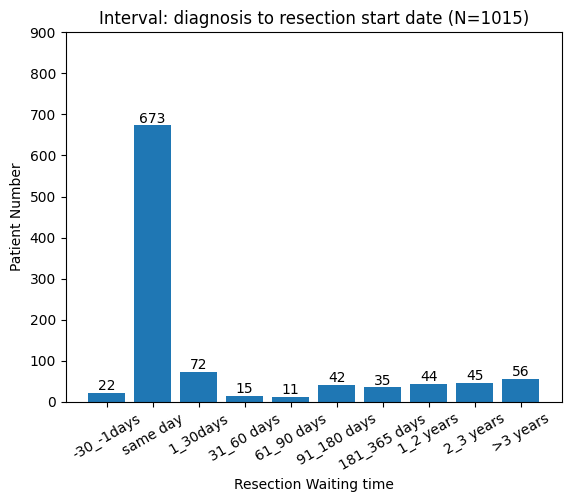

In [29]:
bin = [-31,-1, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
df_surgery.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
df_surgery['DAY_FROM_DIAG_TO_OP_'].replace(r'', np.nan, inplace = True)
df_surgery.dropna(axis=0, subset=['DAY_FROM_DIAG_TO_OP_'], inplace=True)

df_surgery['SafterD'] = pd.cut(df_surgery['DAY_FROM_DIAG_TO_OP_'].astype(float).astype(int), bins = bin, labels=('<-30days','-29_0days','1_30days', '31_60days', '61_90days', '91_180days', '181_365days', '1_2years', '2_3years', '>3years'))
df_surgery.groupby('SafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(df_surgery.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())), df_surgery.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],rotation=30,labels=['-30_-1days','same day','1_30days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
plt.bar_label(BAR)
plt.xlabel('Resection Waiting time')
plt.ylabel('Patient Number')
plt.title('Interval: diagnosis to resection start date (N=1015)')
plt.ylim(0,900)

In [30]:
sd_sameday=df_surgery[df_surgery['DAY_FROM_DIAG_TO_OP_']==0]
sd_sameday['PSEUDO_PATIENTID'].nunique()

673

(0.0, 600.0)

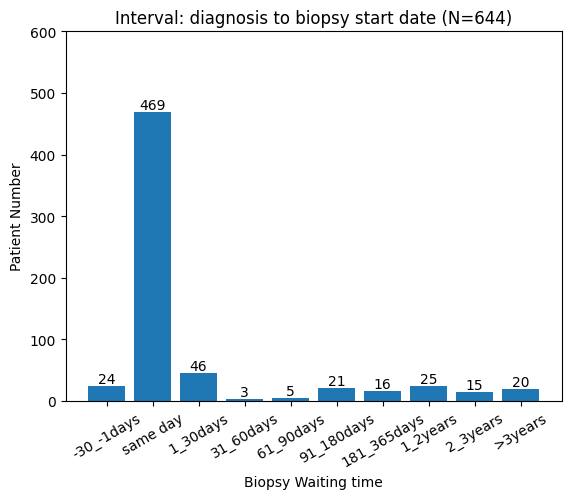

In [31]:
bin = [-31,-1, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
df_biopsy.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
df_biopsy['DAY_FROM_DIAG_TO_OP_'].replace(r'', np.nan, inplace = True)
df_biopsy.dropna(axis=0, subset=['DAY_FROM_DIAG_TO_OP_'], inplace=True)

df_biopsy['SafterD'] = pd.cut(df_biopsy['DAY_FROM_DIAG_TO_OP_'].astype(float).astype(int), bins = bin, labels=('_-30days','-29_0days','1_30days', '31_60days', '61_90days', '91_180days', '181_365days', '1_2years', '2_3years', '>3years'))
df_biopsy.groupby('SafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(df_biopsy.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())), df_biopsy.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],rotation=30,labels=['-30_-1days','same day','1_30days', '31_60days', '61_90days', '91_180days', '181_365days', '1_2years', '2_3years', '>3years'])
plt.bar_label(BAR)
plt.xlabel('Biopsy Waiting time')
plt.ylabel('Patient Number')
plt.title('Interval: diagnosis to biopsy start date (N=644)')
plt.ylim(0,600)

(0.0, 900.0)

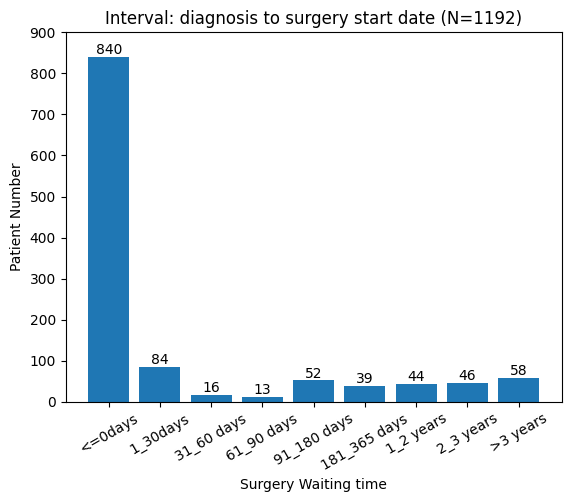

In [32]:
bin = [-31, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
surgery_or_bio.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
surgery_or_bio['DAY_FROM_DIAG_TO_OP_'].replace(r'', np.nan, inplace = True)
surgery_or_bio.dropna(axis=0, subset=['DAY_FROM_DIAG_TO_OP_'], inplace=True)

surgery_or_bio['SafterD'] = pd.cut(surgery_or_bio['DAY_FROM_DIAG_TO_OP_'].astype(float).astype(int), bins = bin, labels=('-29_0days','1_30days', '31_60days', '61_90days', '91_180days', '181_365days', '1_2years', '2_3years', '>3years'))
surgery_or_bio.groupby('SafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(surgery_or_bio.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())), surgery_or_bio.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],rotation=30,labels=['<=0days','1_30days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
plt.bar_label(BAR)
plt.xlabel('Surgery Waiting time')
plt.ylabel('Patient Number')
plt.title('Interval: diagnosis to surgery start date (N=1192)')
plt.ylim(0,900)

## RTDS

In [33]:
##################### FOCUS ON fraction and does in RTDS table ####################################
radio_oligo = pd.read_sql("SELECT * FROM RTDS WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX','')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) );",conn)
print('Total number of patients with oligodendro in RTDS table:', radio_oligo['PSEUDO_PATIENTID'].nunique())
radio_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)


Total number of patients with oligodendro in RTDS table: 823


### oligo could grow on C70 and C72, but we dont have record of C70

In [34]:
######################## Fetch the first 3 characters to get Primary diagnosis start with C71 C72 ###############

radio_oligo['PRIMARYDIAGNOSISICD']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str)
radio_oligo['ICD10']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str).str[:3]

# Creating a dataframe that locks from the original dataframe the patient id and the new ICD10 column
radio_P=radio_oligo[['PSEUDO_PATIENTID','ICD10', 'RTTREATMENTREGION', 'RTPRESCRIBEDDOSE','ACTUALFRACTIONS', 'RTACTUALDOSE','INTERVAL_DIAG_TO_TREAT_START']]

rtds2=pd.read_sql("SELECT * FROM RTDS WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX', '')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) );",conn)
rtds2['PRIMARYDIAGNOSISICD']=rtds2['PRIMARYDIAGNOSISICD'].astype(str)
rtds2['ICD10']=rtds2['PRIMARYDIAGNOSISICD'].astype(str).str[:3]

# Creating three dataframes capturing the patients with different ICD10 codes for brain tumours in each 
rtdsnew=radio_P.loc[(radio_P['ICD10'] == 'C71')]
rtds2new=rtds2.loc[(rtds2['ICD10'] == 'C72' )]

# combining the three dataframes 
rtds=pd.concat([rtdsnew, rtds2new])
print('Number of patients that had an ICD 10 code of C71 or C72:', rtds['PSEUDO_PATIENTID'].nunique())

print('Number of patients without a brain tumour diagnosis in RTDS:', radio_oligo['PSEUDO_PATIENTID'].nunique() - rtds['PSEUDO_PATIENTID'].nunique())


Number of patients that had an ICD 10 code of C71 or C72: 791
Number of patients without a brain tumour diagnosis in RTDS: 32


In [35]:
# Substracting patients that were not treated for their primary diagnosis
region=rtds[['PSEUDO_PATIENTID','RTTREATMENTREGION', 'INTERVAL_DIAG_TO_TREAT_START', 'ACTUALFRACTIONS', 'RTACTUALDOSE', 'RTPRESCRIBEDDOSE']]
region=region.drop_duplicates()
a=(region['PSEUDO_PATIENTID'].nunique())
print('Total number of oligo patients with a brain tumour diagnosis in RTDS:', a)

# Creating a list with the values of the variable (region of treatment) that we want to get numbers for
primary=('P', 'R', 'PR')
# Creating a dataframe that retains only the rows with the values we selected before in the list
prim=region[region.RTTREATMENTREGION.isin(primary)]
# Printing the  number of patients assigned those selected treatments
print(prim['RTTREATMENTREGION'].value_counts())
print('Number of patients with a brain tumour diagnosis in RTDS receiving treatment to their primary site:', prim['PSEUDO_PATIENTID'].nunique())

Total number of oligo patients with a brain tumour diagnosis in RTDS: 791
P     760
PR      1
Name: RTTREATMENTREGION, dtype: int64
Number of patients with a brain tumour diagnosis in RTDS receiving treatment to their primary site: 760


In [36]:
# reassignment: from RTDS patients who had ICD10 code of C70 C71 and C72, and received treatment to their primary sites
r_oligo=prim
r_oligo.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
r_oligo['PSEUDO_PATIENTID'].nunique()

/tmp/ipykernel_4019872/3793976419.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



760

## Combine cleaned rtds data with data in TUM_PAT

In [37]:
r_oligo=pd.merge(r_oligo, df, on='PSEUDO_PATIENTID')

In [38]:
r_oligo['PSEUDO_PATIENTID'].nunique()

749

In [39]:
r_oligo['RTPRESCRIBEDDOSE'].replace(r'',np.nan,inplace=True)
r_oligo.dropna(subset='RTPRESCRIBEDDOSE', inplace=True)
print(r_oligo['PSEUDO_PATIENTID'].nunique())

748


In [40]:
r_oligo['RTACTUALDOSE'].replace(r'',np.nan,inplace=True)
r_oligo.dropna(subset='RTACTUALDOSE', inplace=True)
print(r_oligo['PSEUDO_PATIENTID'].nunique())

475


In [41]:
r_oligo['ACTUALFRACTIONS'].replace(r'',np.nan,inplace=True)
r_oligo.dropna(subset='ACTUALFRACTIONS', inplace=True)
print(r_oligo['PSEUDO_PATIENTID'].nunique())

475


In [42]:
r_oligo.groupby('SEX')['PSEUDO_PATIENTID'].nunique()

SEX
1    250
2    225
Name: PSEUDO_PATIENTID, dtype: int64

## RT Doses oligo patients received

In [43]:
# ACtual Fractions
bin = [0, 10, 20, 30, 40, 50, 60]
r_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
r_oligo['ACTUALFRACTIONS'].replace(r'', np.nan, inplace = True)
r_oligo.dropna(axis=0, subset=['ACTUALFRACTIONS'], inplace=True)

DOSE = pd.cut(r_oligo['ACTUALFRACTIONS'].astype(float).astype(int), bins = bin)
DOSE.value_counts(sort=False).to_frame()

,ACTUALFRACTIONS
"(0, 10]",23
"(10, 20]",20
"(20, 30]",321
"(30, 40]",106
"(40, 50]",5
"(50, 60]",0


In [44]:
r_oligo['RTACTUALDOSE'].describe()

count    475.000000
mean      27.273003
std       16.000902
min        1.800000
25%       14.400000
50%       26.000000
75%       36.000000
max       60.156342
Name: RTACTUALDOSE, dtype: float64

## RT fractions oligo patients  received

In [45]:
# Fractions describe
r_oligo['ACTUALFRACTIONS'].describe()

count     475
unique     35
top        30
freq      263
Name: ACTUALFRACTIONS, dtype: int64

In [46]:
# Fractions median
statistics.median(r_oligo['ACTUALFRACTIONS'])

30

## DOSEby grades

/tmp/ipykernel_4019872/3536779182.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/3536779182.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/3536779182.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/3536779182.py:16: SettingWithCopyWarning:



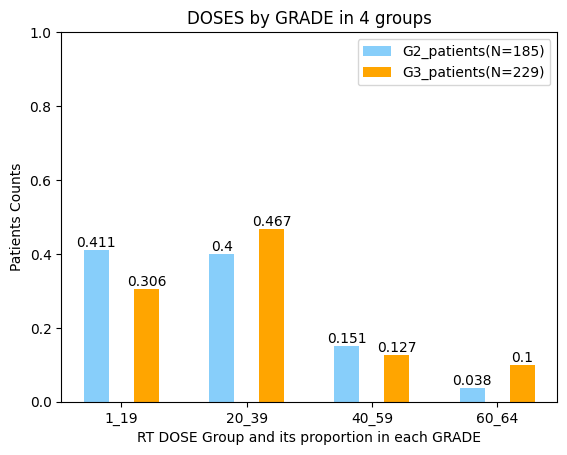

In [47]:
radio_G2=r_oligo[r_oligo.GRADE=='G2']
radio_G3=r_oligo[r_oligo.GRADE=='G3']

radio_G2.loc[(0 < radio_G2.RTACTUALDOSE) & (radio_G2.RTACTUALDOSE < 20), 'RTgroup'] = '1_19'
radio_G2.loc[(19 < radio_G2.RTACTUALDOSE) & (radio_G2.RTACTUALDOSE < 40), 'RTgroup'] = '20_39'
radio_G2.loc[(39 < radio_G2.RTACTUALDOSE) & (radio_G2.RTACTUALDOSE < 60), 'RTgroup'] = '40_59'
radio_G2.loc[(59 < radio_G2.RTACTUALDOSE) & (radio_G2.RTACTUALDOSE < 65), 'RTgroup'] = '60_64'

radio_G3.loc[(0 < radio_G3.RTACTUALDOSE) & (radio_G3.RTACTUALDOSE < 20), 'RTgroup'] = '1_19'
radio_G3.loc[(19 < radio_G3.RTACTUALDOSE) & (radio_G3.RTACTUALDOSE < 40), 'RTgroup'] = '20_39'
radio_G3.loc[(39 < radio_G3.RTACTUALDOSE) & (radio_G3.RTACTUALDOSE < 60), 'RTgroup'] = '40_59'
radio_G3.loc[(59 < radio_G3.RTACTUALDOSE) & (radio_G3.RTACTUALDOSE < 65), 'RTgroup'] = '60_64'

# drop_duplicates in case any repeat
radio_G2.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
radio_G3.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)


# use one charc to carry the bar plot
G2 = plt.bar(np.arange(len(radio_G2.groupby('RTgroup')['SEX'].count()))-0.2, [round(i,3) for i in (radio_G2.groupby('RTgroup')['SEX'].count())/185], width=0.2,color='lightskyblue', label = 'G2_patients(N=185)')
G3 = plt.bar(np.arange(len(radio_G3.groupby('RTgroup')['SEX'].count()))+0.2, [round(i,3) for i in (radio_G3.groupby('RTgroup')['SEX'].count())/229],width=0.2, color='orange', label = 'G3_patients(N=229)')

# Show statistics
plt.xticks([0, 1, 2, 3],labels=['1_19', '20_39', '40_59', '60_64'])
plt.ylim(0, 1)
plt.xlabel('RT DOSE Group and its proportion in each GRADE')
plt.ylabel('Patients Counts')
plt.title('DOSES by GRADE in 4 groups')
plt.bar_label(G2)
plt.bar_label(G3)
plt.legend()


In [48]:
from scipy.stats import kstest
kstest(radio_G2['RTACTUALDOSE'],'norm')

KstestResult(statistic=0.9728076339922529, pvalue=4.7176365183617e-290)

In [49]:
# stat_val, p_val = stats.ttest_ind(radio_G2['RTACTUALDOSE'], radio_G3['RTACTUALDOSE'], equal_var=False)
# print('2 sample t test p value,', p_val)

In [50]:
from scipy import stats
stat_val, p_val = stats.mannwhitneyu(radio_G2['RTACTUALDOSE'], radio_G3['RTACTUALDOSE'])
print('2 sample Mann Whitney test p value,', p_val)

2 sample Mann Whitney test p value, 0.05808501987326427


(0.0, 200.0)

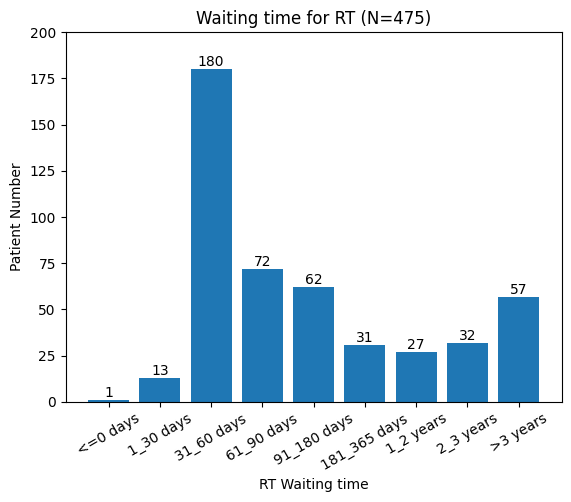

In [51]:
bin = [-100000, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
r_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
r_oligo['INTERVAL_DIAG_TO_TREAT_START'].replace(r'', np.nan, inplace = True)
r_oligo.dropna(axis=0, subset=['INTERVAL_DIAG_TO_TREAT_START'], inplace=True)

r_oligo['RTafterD'] = pd.cut(r_oligo['INTERVAL_DIAG_TO_TREAT_START'].astype(float).astype(int), bins = bin, labels=('SACT before Diag','0_29days', '30_59days', '60_89days', '90_179days', '180_364days', '1_2years', '2_3years', '>3years'))
r_oligo.groupby('RTafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(r_oligo.groupby('RTafterD')['PSEUDO_PATIENTID'].nunique())), r_oligo.groupby('RTafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],rotation=30,labels=['<=0 days','1_30 days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
plt.bar_label(BAR)
plt.xlabel('RT Waiting time')
plt.ylabel('Patient Number')
plt.title('Waiting time for RT (N=475)')
plt.ylim(0,200)


# SACT

In [52]:
# fetch the first 3 characters to get patients diagnosis code starting with C70/C71/C72
c_oligo = pd.read_sql("SELECT * FROM SACT WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX', '')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
c_oligo.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
c_oligo['PRIMARY_DIAGNOSIS']=c_oligo['PRIMARY_DIAGNOSIS'].astype(str)
c_oligo['site_ICD10']=c_oligo['PRIMARY_DIAGNOSIS'].astype(str).str[:3]

print('Patients number in SACT before cleaning:', c_oligo['PSEUDO_PATIENTID'].nunique())

# Choose the columns that we may need
chemo_icd=c_oligo[['PSEUDO_PATIENTID','site_ICD10','INTENT_OF_TREATMENT','MORPHOLOGY_CLEAN', 'BENCHMARK_GROUP','CYCLE_NUMBER','INTERVAL_DIAG_START_REGIMEN', 'DRUG_GROUP']]
chemo_icd.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

# Selecting patients that have a brain tumour diagnosis code in SACT 
diagnosis=('C71', 'C72')
chemo_bt=chemo_icd[chemo_icd.site_ICD10.isin(diagnosis)]
print(chemo_bt['site_ICD10'].value_counts())
print('Number of patients with a brain tumour diagnosis in SACT:', chemo_bt['PSEUDO_PATIENTID'].nunique())

Patients number in SACT before cleaning: 749
C71    697
C72      3
Name: site_ICD10, dtype: int64
Number of patients with a brain tumour diagnosis in SACT: 700


/tmp/ipykernel_4019872/2990457426.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
## reassign chemo_bt to chemo_oligo
chemo_oligo=pd.merge(chemo_bt, df,on='PSEUDO_PATIENTID')
chemo_oligo['PSEUDO_PATIENTID'].nunique()

691

## Check waiting time for SACT

(0.0, 350.0)

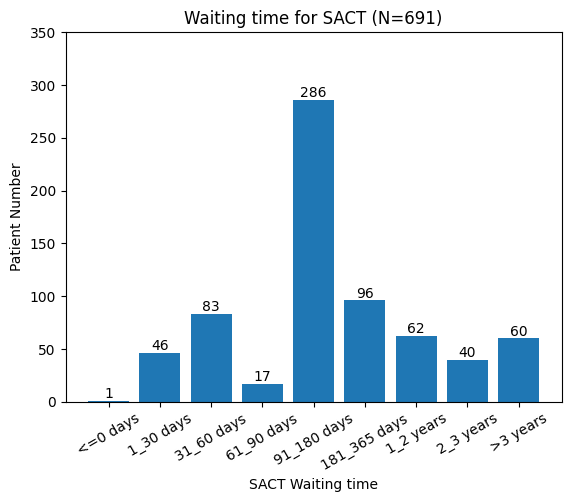

In [54]:
bin = [-100000, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
chemo_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
chemo_oligo['INTERVAL_DIAG_START_REGIMEN'].replace(r'', np.nan, inplace = True)
chemo_oligo.dropna(axis=0, subset=['INTERVAL_DIAG_START_REGIMEN'], inplace=True)

chemo_oligo['TafterD'] = pd.cut(chemo_oligo['INTERVAL_DIAG_START_REGIMEN'].astype(float).astype(int), bins = bin, labels=('SACT before Diag','0_29days', '30_59days', '60_89days', '90_179days', '180_364days', '1_2years', '2_3years', '>3years'))
chemo_oligo.groupby('TafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(chemo_oligo.groupby('TafterD')['PSEUDO_PATIENTID'].nunique())), chemo_oligo.groupby('TafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],rotation=30,labels=['<=0 days','1_30 days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
plt.bar_label(BAR)
plt.xlabel('SACT Waiting time')
plt.ylabel('Patient Number')
plt.title('Waiting time for SACT (N=691)')
plt.ylim(0, 350)


## PCV + RT vs RT only, after patients underwent surgery

In [55]:
# Meihua Wang's paper(2009) has mentioned that PCV+RT could increase median sirvival time
# let's check if PCV+RT group's survival curve is really better than RT only

# use ~.isin() to clear patients who might underwent other chemo_therapy
RT_only_stillhave_surgery = r_oligo[~r_oligo['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]

# ~isin surgery_or_biopsy is not recommended since surgery is the basis of all kinds of treatments
RT_only = RT_only_stillhave_surgery[RT_only_stillhave_surgery['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

print('Number of patients who only had RT after surgery:',RT_only['PSEUDO_PATIENTID'].nunique())



Number of patients who only had RT after surgery: 96


In [56]:
## pcv have 2 drug groups, PCV and 'procarbazine + lomustine + vincristine

pcv = pd.read_sql("SELECT * FROM SACT WHERE BENCHMARK_GROUP IN ('PCV', 'LOMUSTINE + PROCARBAZINE + VINCRISTINE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
PCV_RT = pd.merge(pcv, r_oligo, on = 'PSEUDO_PATIENTID')

# don't forget to choose those in C70/C71/C72 diagnosis
# diagnosis=('C70', 'C71', 'C72'), fetch the first 3 characters in Primary diagnosis column of new dataframe to double check
PCV_RT=Fetch_first(PCV_RT)
PCV_RT=PCV_RT[PCV_RT.site_ICD10.isin(diagnosis)]

# and choose those also underwent surgery in new version of codes
PCV_RT = PCV_RT[PCV_RT['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

print('Number of patients who have only undergone pcv + RT treatment after surgery:',PCV_RT['PSEUDO_PATIENTID'].nunique())


Number of patients who have only undergone pcv + RT treatment after surgery: 275


In [57]:
# RT_only_exclude_Chemo['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
# RT_only_exclude_Chemo.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
# RT_only_exclude_Chemo['VITALSTATUS_NEW'] = RT_only_exclude_Chemo.apply(conditions, axis = 1)
# kmf = KaplanMeierFitter()
# kmf.fit(durations = RT_only_exclude_Chemo['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = RT_only_exclude_Chemo['VITALSTATUS_NEW'], label = 'RT only')
# kmf.plot()
# print('Median survival RT_only: ', kmf.median_survival_time_)

# PCV_RT_mighthave_S['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
# PCV_RT_mighthave_S.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
# PCV_RT_mighthave_S['VITALSTATUS_NEW'] = PCV_RT_mighthave_S.apply(conditions, axis = 1)
# kmf = KaplanMeierFitter()
# kmf.fit(durations = PCV_RT_mighthave_S['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = PCV_RT_mighthave_S['VITALSTATUS_NEW'], label = 'PCV + RT')
# kmf.plot()
# print('Median survival PCV_RT: ', kmf.median_survival_time_)

# plt.xlabel('Time(days)')
# plt.ylabel('Survival probability')
# plt.title('Survival of oligo patients: PCV+RT vs RT only')

# To note, these groups might contain surgeries as basis of treatments

# It is strange at the late stage of curves, maybe resections were already enough for recovery, and RT is a good adjuctive choice


/tmp/ipykernel_4019872/3268133030.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/3268133030.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/3268133030.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Median survival RT_only:  inf
Median survival PCV_RT:  inf


Text(0.5, 1.0, 'Survival of oligo patients: PCV+RT vs RT only')

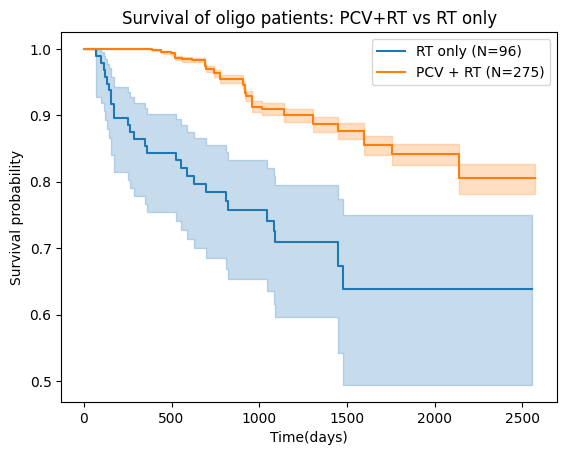

In [58]:
kmf=KaplanMeierFitter()
# never forget to drop NA before kmf
RT_only['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
RT_only.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
RT_only['VITALSTATUS_NEW'] = RT_only.apply(conditions, axis = 1)

# give a name to the fitter for later log_rank test
rt=kmf.fit(durations = RT_only['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = RT_only['VITALSTATUS_NEW'], label = 'RT only (N=96)')
kmf.plot()
print('Median survival RT_only: ', kmf.median_survival_time_)

PCV_RT['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
PCV_RT.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
PCV_RT['VITALSTATUS_NEW'] = PCV_RT.apply(conditions, axis = 1)

# give a name to the fitter for later log_rank test
pcv_rt=kmf.fit(durations = PCV_RT['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = PCV_RT['VITALSTATUS_NEW'], label = 'PCV + RT (N=275)')
kmf.plot()
print('Median survival PCV_RT: ', kmf.median_survival_time_)

plt.xlabel('Time(days)')
plt.ylabel('Survival probability')
plt.title('Survival of oligo patients: PCV+RT vs RT only')

# this comparison is way more clear 

In [59]:
PR_results = logrank_test(PCV_RT['INTERVAL_DIAG_TO_VS'], RT_only['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = PCV_RT.apply(conditions,axis=1).astype(int),
                       event_observed_B = RT_only.apply(conditions,axis=1).astype(int))
PR_results.print_summary()
# Great, now this comparison can be defined as valid

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          46.77 <0.005     36.87

## To compare TMZ only vs TMZ+RT, the conservative way is to query only in benchmark_group, however it would make the patient number in TMZ+RT group looks too small

In [60]:
## left merge, same for TMZ+RT
tmz = pd.read_sql("SELECT * FROM SACT WHERE BENCHMARK_GROUP IN ('TEMOZOLOMIDE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
TMZ = pd.merge(tmz, df, on = 'PSEUDO_PATIENTID')
print('before site_icd10 cleaning, patient number of TMZ only Group:', TMZ['PSEUDO_PATIENTID'].nunique())

# diagnosis=('C70', 'C71', 'C72'), fetch the first 3 characters in Primary diagnosis column of new dataframe to double check
TMZ['PRIMARY_DIAGNOSIS']=TMZ['PRIMARY_DIAGNOSIS'].astype(str)
TMZ['site_ICD10']=TMZ['PRIMARY_DIAGNOSIS'].astype(str).str[:3]
TMZ_clean=TMZ[TMZ.site_ICD10.isin(diagnosis)]
print('after cleaning patients who dont have C70/C71/C72 codes:', TMZ_clean['PSEUDO_PATIENTID'].nunique())

TMZ_clean_exradio = TMZ_clean[~TMZ_clean['PSEUDO_PATIENTID'].isin(r_oligo['PSEUDO_PATIENTID'])]
print('after excluding patients in RTDS, patient number:',TMZ_clean_exradio['PSEUDO_PATIENTID'].nunique())

# and choose those also underwent surgery in new version of codes
TMZ_final = TMZ_clean_exradio[TMZ_clean_exradio['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

print('Number of patients who have only undergone TMZ treatment after surgery:',TMZ_final['PSEUDO_PATIENTID'].nunique())


before site_icd10 cleaning, patient number of TMZ only Group: 326
after cleaning patients who dont have C70/C71/C72 codes: 307
after excluding patients in RTDS, patient number: 160
Number of patients who have only undergone TMZ treatment after surgery: 154


In [61]:
## add a group to TMZ_inradio since only quering TMZ+RT in Benchamark group, N is too small

TMZ_clean_inradio = TMZ_clean[TMZ_clean['PSEUDO_PATIENTID'].isin(r_oligo['PSEUDO_PATIENTID'])]
TMZ_clean_inradio['PSEUDO_PATIENTID'].nunique()


147

In [62]:
## TMZ+RT
tmz_rt = pd.read_sql("SELECT * FROM SACT WHERE BENCHMARK_GROUP IN ('TEMOZOLOMIDE + RT') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
TMZ_RT = pd.merge(tmz_rt, df, on = 'PSEUDO_PATIENTID', how='left')
print('before site_icd10 cleaning, patient number of TMZ+RT benchmark Group:', TMZ_RT['PSEUDO_PATIENTID'].nunique())

# diagnosis=('C70', 'C71', 'C72'), fetch the first 3 characters in Primary diagnosis column of new dataframe to double check
TMZ_RT['PRIMARY_DIAGNOSIS']=TMZ_RT['PRIMARY_DIAGNOSIS'].astype(str)
TMZ_RT['site_ICD10']=TMZ_RT['PRIMARY_DIAGNOSIS'].astype(str).str[:3]
TMZ_RTclean=TMZ_RT[TMZ_RT.site_ICD10.isin(diagnosis)]
print('after cleaning patients who dont have C70/C71/C72 codes, TMZ+RT benchmark Group:', TMZ_RTclean['PSEUDO_PATIENTID'].nunique())

# make sure no matter TMZ+RT benchmark group or TMZalsoinRTDS group all in RTDS table
TMZplusRT_clean = TMZ_RTclean[TMZ_RTclean['PSEUDO_PATIENTID'].isin(r_oligo['PSEUDO_PATIENTID'])]
TMZ_concat=pd.concat([TMZplusRT_clean, TMZ_clean_inradio])
print('after locking patients in RTDS and concat TMZinRTDS group, patient number:',TMZ_concat['PSEUDO_PATIENTID'].nunique())

# and choose those also underwent surgery in new version of codes
TMZ_RTfinal = TMZ_concat[TMZ_concat['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

print('Number of patients who have undergone TMZ and RTtreatment after surgery:',TMZ_RTfinal['PSEUDO_PATIENTID'].nunique())


before site_icd10 cleaning, patient number of TMZ+RT benchmark Group: 85
after cleaning patients who dont have C70/C71/C72 codes, TMZ+RT benchmark Group: 77
after locking patients in RTDS and concat TMZinRTDS group, patient number: 149
Number of patients who have undergone TMZ and RTtreatment after surgery: 145


/tmp/ipykernel_4019872/413356648.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/413356648.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/413356648.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/413356648.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Text(0.5, 1.0, 'Survival of oligo patients: TMZ+RT vs TMZ only')

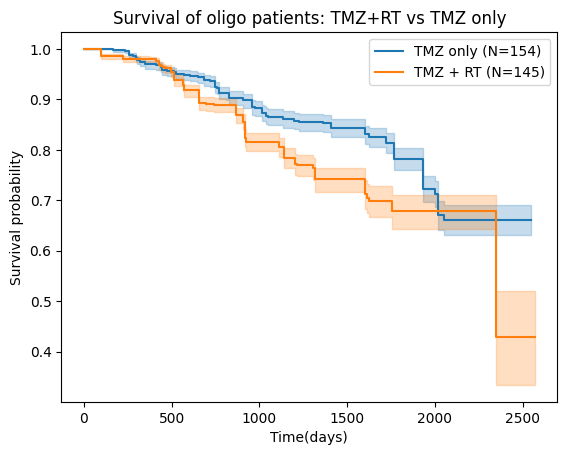

In [63]:
# never forget to drop NA before kmf
TMZ_final['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
TMZ_final.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
TMZ_final['VITALSTATUS_NEW'] = TMZ_final.apply(conditions, axis = 1)
kmf=KaplanMeierFitter()
tmz=kmf.fit(durations = TMZ_final['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_final['VITALSTATUS_NEW'], label = 'TMZ only (N=154)')
kmf.plot()

TMZ_RTfinal['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
TMZ_RTfinal.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
TMZ_RTfinal['VITALSTATUS_NEW'] = TMZ_RTfinal.apply(conditions, axis = 1)
tmz_rt=kmf.fit(durations = TMZ_RTfinal['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_RTfinal['VITALSTATUS_NEW'], label = 'TMZ + RT (N=145)')
kmf.plot()

plt.xlabel('Time(days)')
plt.ylabel('Survival probability')
plt.title('Survival of oligo patients: TMZ+RT vs TMZ only')


## Significant difference found, but we could also check their sequences later, since we don't know which contribute more to this result, TMZ+RT or RT+TMZ? 

In [64]:
TR_results = logrank_test(TMZ_final['INTERVAL_DIAG_TO_VS'], TMZ_RTfinal['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = TMZ_final.apply(conditions,axis=1).astype(int),
                       event_observed_B = TMZ_RTfinal.apply(conditions,axis=1).astype(int))
TR_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          34.01 <0.005     27.44

## Build groups for seqs

In [65]:
## prim is almost same with r_oligo, just did not merge with df
rtds_oligo=prim

# and only select the useful column
rtds_oligo=rtds_oligo[['PSEUDO_PATIENTID', 'INTERVAL_DIAG_TO_TREAT_START']]
TMZ_RTfinal=TMZ_RTfinal[['PSEUDO_PATIENTID', 'INTERVAL_DIAG_START_REGIMEN']]

# drop NA and duplicates
TMZ_RTfinal.dropna(subset='INTERVAL_DIAG_START_REGIMEN', axis=0)
TMZ_RTfinal.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
rtds_oligo.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

/tmp/ipykernel_4019872/1198997592.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
# Merge TMZ_RTfinal with oligo patients in RTDS, and df in order to applay kmf
TMZ_RT_withT=pd.merge(TMZ_RTfinal, rtds_oligo)
TMZ_RT_withI=pd.merge(TMZ_RT_withT, df, how='left')
TMZ_RT_withI.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
print('after merging with patients in RTDS and TUM_PAT, patient number:' ,TMZ_RT_withI['PSEUDO_PATIENTID'].nunique())


after merging with patients in RTDS and TUM_PAT, patient number: 145


In [67]:
TMZ_RT_withI.loc[(TMZ_RT_withI.INTERVAL_DIAG_TO_TREAT_START > TMZ_RT_withI.INTERVAL_DIAG_START_REGIMEN), 'seq'] = 'TMZ_then_RT'
TMZ_RT_withI.loc[(TMZ_RT_withI.INTERVAL_DIAG_TO_TREAT_START < TMZ_RT_withI.INTERVAL_DIAG_START_REGIMEN), 'seq'] = 'RT_then_TMZ'
TMZ_RT_withI.loc[(TMZ_RT_withI.INTERVAL_DIAG_TO_TREAT_START == TMZ_RT_withI.INTERVAL_DIAG_START_REGIMEN), 'seq'] = 'RT_TMZsame'
# os.chdir('/home/ll6222/Documents/DS175/share/19_Rare tumours')
# TMZ_RT_withT.to_csv('TMZ RT seq survival comparison.csv')

# these codes looks very repeated but practical
tmz_then_rt='TMZ_then_RT'
tmz_then_rt=TMZ_RT_withI.query('seq in @tmz_then_rt')
print('tmz,then rt',tmz_then_rt['PSEUDO_PATIENTID'].nunique())

rt_then_tmz='RT_then_TMZ'
rt_then_tmz=TMZ_RT_withI.query('seq in @rt_then_tmz')
print('rt,then tmz',rt_then_tmz['PSEUDO_PATIENTID'].nunique())

tmz_rt_s='RT_TMZsame'
tmz_rt_s=TMZ_RT_withI.query('seq in @tmz_rt_s')
print('tmz and rt smae time',tmz_rt_s['PSEUDO_PATIENTID'].nunique())


tmz,then rt 60
rt,then tmz 79
tmz and rt smae time 6


/tmp/ipykernel_4019872/597192751.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/597192751.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/597192751.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/597192751.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Text(0, 0.5, 'Survival Probability')

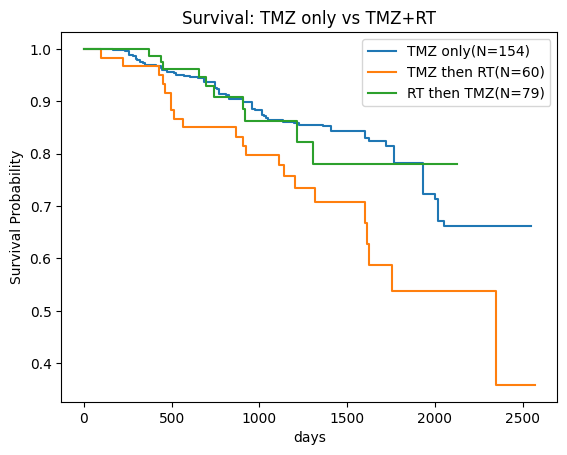

In [68]:

TMZ_final['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
TMZ_final.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
TMZ_final['VITALSTATUS_NEW'] = TMZ_final.apply(conditions, axis = 1)
tmz=kmf.fit(durations = TMZ_final['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_final['VITALSTATUS_NEW'], label = 'TMZ only(N=154)')
kmf.plot(ci_show=False)

tmz_then_rt['VITALSTATUS_NEW'] = tmz_then_rt.apply(conditions, axis = 1)
TMZ_RT=kmf.fit(durations = tmz_then_rt['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = tmz_then_rt['VITALSTATUS_NEW'], label = 'TMZ then RT(N=60)')
kmf.plot(ci_show=False)

rt_then_tmz['VITALSTATUS_NEW'] = rt_then_tmz.apply(conditions, axis = 1)
rt_tmz=kmf.fit(durations = rt_then_tmz['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = rt_then_tmz['VITALSTATUS_NEW'], label = 'RT then TMZ(N=79)')
kmf.plot(ci_show=False)

# tmz_rt_s['VITALSTATUS_NEW'] = tmz_rt_s.apply(conditions, axis = 1)
# tmz_rt_same=kmf.fit(durations = tmz_rt_s['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = tmz_rt_s['VITALSTATUS_NEW'], label = 'TMZ_RT same time(N=6)')
# kmf.plot(ci_show=False)

plt.title('Survival: TMZ only vs TMZ+RT')
plt.xlabel('days')
plt.ylabel('Survival Probability')

In [69]:
Tonly_RTthenTMZ_results = logrank_test(TMZ_final['INTERVAL_DIAG_TO_VS'], rt_then_tmz['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = TMZ_final.apply(conditions,axis=1).astype(int),
                       event_observed_B = rt_then_tmz.apply(conditions,axis=1).astype(int))
Tonly_RTthenTMZ_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.17 0.68      0.56

In [70]:
Tonly_TMZthenRT_results = logrank_test(TMZ_final['INTERVAL_DIAG_TO_VS'], tmz_then_rt['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = TMZ_final.apply(conditions,axis=1).astype(int),
                       event_observed_B = tmz_then_rt.apply(conditions,axis=1).astype(int))
Tonly_TMZthenRT_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.97 <0.005     10.08

## Discovery into PCV comparing with TMZ (plus RT or not)

In [71]:
## build a group for PCV only
pcv = pd.read_sql("SELECT * FROM SACT WHERE BENCHMARK_GROUP IN ('PCV', 'LOMUSTINE + PROCARBAZINE + VINCRISTINE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)

## not in RTDS
pcv_only = pcv[~pcv['PSEUDO_PATIENTID'].isin(r_oligo['PSEUDO_PATIENTID'])]

# don't forget to choose those in C70/C71/C72 diagnosis
# diagnosis=('C70', 'C71', 'C72'), fetch the first 3 characters in Primary diagnosis column of new dataframe to double check
pcv_only=Fetch_first(pcv_only)

pcv_only=pcv_only[pcv_only.site_ICD10.isin(diagnosis)]

# and choose those also underwent surgery in new version of codes
pcv_only = pcv_only[pcv_only['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

# and merge it with TUM_PAT for KaplanMeier 's applicaiton
pcv_only=pd.merge(df,pcv_only, on='PSEUDO_PATIENTID')
print('pcv only patients count',pcv_only['PSEUDO_PATIENTID'].nunique())

pcv only patients count 194


/tmp/ipykernel_4019872/684434533.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/684434533.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_4019872/684434533.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/684434533.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/2080809141.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.0, 1.0302169052325554)

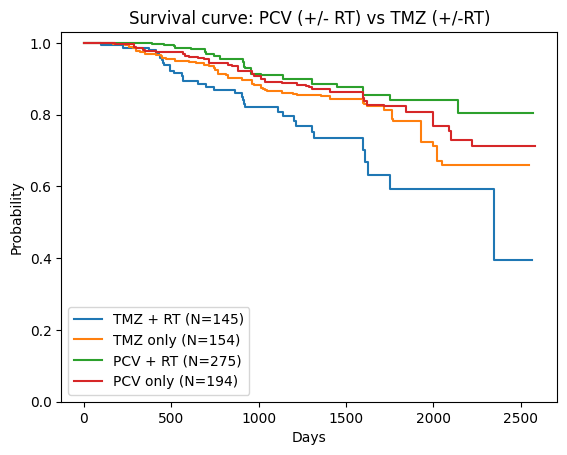

In [72]:
## PCV RT vs TMZ RT vs TMZ only vs PCV only
TMZ_RT_withI=Drop(TMZ_RT_withI)
TMZ_RT_withI['VITALSTATUS_NEW'] = TMZ_RT_withI.apply(conditions, axis = 1)
tmz_rt=kmf.fit(durations = TMZ_RT_withI['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_RT_withI['VITALSTATUS_NEW'], label = 'TMZ + RT (N=145)')
kmf.plot(ci_show=False)

TMZ_final=Drop(TMZ_final)
TMZ_final['VITALSTATUS_NEW'] = TMZ_final.apply(conditions, axis = 1)
tmz=kmf.fit(durations = TMZ_final['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_final['VITALSTATUS_NEW'], label = 'TMZ only (N=154)')
kmf.plot(ci_show=False)

PCV_RT=Drop(PCV_RT)
PCV_RT['VITALSTATUS_NEW'] = PCV_RT.apply(conditions, axis = 1)
pcv_rt=kmf.fit(durations = PCV_RT['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = PCV_RT['VITALSTATUS_NEW'], label = 'PCV + RT (N=275)')
kmf.plot(ci_show=False)

pcv_only=Drop(pcv_only)
pcv_only['VITALSTATUS_NEW'] = pcv_only.apply(conditions, axis = 1)
pcv=kmf.fit(durations = pcv_only['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = pcv_only['VITALSTATUS_NEW'], label = 'PCV only (N=194)')
kmf.plot(ci_show=False)

plt.xlabel('Days')
plt.title('Survival curve: PCV (+/- RT) vs TMZ (+/-RT)')
plt.ylabel('Probability')
plt.ylim(0,)

In [73]:
PCVRT_PCVonly_results = logrank_test(PCV_RT['INTERVAL_DIAG_TO_VS'], pcv_only['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = PCV_RT.apply(conditions,axis=1).astype(int),
                       event_observed_B = pcv_only.apply(conditions,axis=1).astype(int))
PCVRT_PCVonly_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.95 <0.005     16.19

In [74]:
PCVRT_TMZonly_results = logrank_test(PCV_RT['INTERVAL_DIAG_TO_VS'], TMZ_final['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = PCV_RT.apply(conditions,axis=1).astype(int),
                       event_observed_B = TMZ_final.apply(conditions,axis=1).astype(int))
PCVRT_TMZonly_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          62.72 <0.005     48.57

In [75]:
pcv = pd.read_sql("SELECT * FROM SACT WHERE (PRIMARY_DIAGNOSIS LIKE 'C71_' or 'C72_') AND BENCHMARK_GROUP IN ('PCV', 'LOMUSTINE + PROCARBAZINE + VINCRISTINE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
pcv=pd.merge(pcv,df,on='PSEUDO_PATIENTID')

pcv.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
print('after SITE_ICD10 cleaning, PCV patient number',pcv['PSEUDO_PATIENTID'].nunique())

tmz = pd.read_sql("SELECT * FROM SACT WHERE (PRIMARY_DIAGNOSIS LIKE 'C71_' or 'C72_') AND BENCHMARK_GROUP IN ('TEMOZOLOMIDE', 'TEMOZOLOMIDE + RT') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
tmz = pd.merge(tmz, df, on = 'PSEUDO_PATIENTID')

tmz.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
print('after SITE_ICD10 cleaning, TMZ patient number', tmz['PSEUDO_PATIENTID'].nunique())


after SITE_ICD10 cleaning, PCV patient number 458
after SITE_ICD10 cleaning, TMZ patient number 299


## Cox version 5

In [76]:
## firstly we need to deal with NA in GRADE
df['GRADE'].replace('','GX', inplace=True)
df['GRADE'].replace('GX','NOS', inplace=True)
df_cox=df[['PSEUDO_PATIENTID','BIGTUMOURCOUNT','AGE', 'SEX', 'INCOME_QUINTILE_2015', 'ETHNICITYNAME', 'GRADE', 'VITALSTATUS', 'INTERVAL_DIAG_TO_VS', 'SITE_ICD10_O2']]

# Clean data as usual
df_cox['VITALSTATUS'].replace(r'A', 0, inplace=True)
df_cox['VITALSTATUS'].replace(r'D', 1, inplace=True)

## black, asian, white and NOS
df_cox['ETHNICITYNAME'].replace('ANY OTHER BLACK BACKGROUND', 'BLACK', inplace=True)
df_cox['ETHNICITYNAME'].replace('BLACK AFRICAN', 'BLACK', inplace=True)
df_cox['ETHNICITYNAME'].replace('BLACK CARIBBEAN', 'BLACK', inplace=True)

df_cox['ETHNICITYNAME'].replace('CHINESE', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ASIAN INDIAN', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ASIAN PAKISTANI', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER ASIAN BACKGROUND', 'ASIAN', inplace=True)

df_cox['ETHNICITYNAME'].replace('WHITE IRISH', 'WHITE', inplace=True)
df_cox['ETHNICITYNAME'].replace('WHITE BRITISH', 'WHITE', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER WHITE BACKGROUND', 'WHITE', inplace=True)

df_cox['ETHNICITYNAME'].replace('ANY OTHER MIXED BACKGROUND', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('NOT KNOWN', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('NOT STATED', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER ETHNIC GROUP', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER MIXED BACKGROUND', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('MIXED WHITE AND ASIAN', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('MIXED WHITE AND BLACK CARIBBEAN', 'Ethnicity NOS', inplace=True)

## C71 and C72
df_cox['SITE_ICD10_O2'].replace('C725', 'C72', inplace=True)

df_cox['SITE_ICD10_O2'].replace('C710', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C711', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C712', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C713', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C714', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C716', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C718', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C719', 'C71', inplace=True)

## Most/middle/Least deprived
df_cox['INCOME_QUINTILE_2015'].replace('1 - Least deprived', 'Least deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('2', 'Least deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('3', 'Middle deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('4', 'Most deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('5 - Most deprived', 'Most deprived', inplace=True)

/tmp/ipykernel_4019872/141639176.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/141639176.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/141639176.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/141639176.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [77]:
df_cox['curative_RT']=0
df_cox['palliative_RT']=0

df_cox['PCV-Palliative']=0
df_cox['PCV-Curative']=0
# df_cox['PCV-Adjuvant']=0

df_cox['TMZ-Palliative']=0
df_cox['TMZ-Curative']=0
# df_cox['TMZ-Adjuvant']=0

df_cox['Resection']=0
df_cox['Biopsy']=0

/tmp/ipykernel_4019872/2268155444.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/2268155444.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4019872/2268155444.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [78]:
pcv_r=pcv[pcv.INTENT_OF_TREATMENT == 'C']
pcv_p=pcv[pcv.INTENT_OF_TREATMENT == 'P']
pcv_a=pcv[pcv.INTENT_OF_TREATMENT == 'A']
pcv_n=pcv[pcv.INTENT_OF_TREATMENT == 'N']

tmz_r=tmz[tmz.INTENT_OF_TREATMENT == 'C']
tmz_p=tmz[tmz.INTENT_OF_TREATMENT == 'P']
tmz_a=tmz[tmz.INTENT_OF_TREATMENT == 'A']
tmz_n=tmz[tmz.INTENT_OF_TREATMENT == 'N']

radio_oligo['RTACTUALDOSE'].replace('',np.nan,inplace=True)
radio_oligo.dropna(subset='RTACTUALDOSE', axis=0, inplace=True)

curative_r = radio_oligo.query('RTACTUALDOSE > 40')
palliative_r = radio_oligo.query('RTACTUALDOSE <= 40')

In [79]:
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(curative_r['PSEUDO_PATIENTID']), 'curative_RT'] = 1 # N=89
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(palliative_r['PSEUDO_PATIENTID']), 'palliative_RT'] = 1 # N=386

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_p['PSEUDO_PATIENTID']), 'PCV-Palliative'] = 1  # N=59
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_r['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=17
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_a['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=203
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_n['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=2, N(curative)=222

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_p['PSEUDO_PATIENTID']), 'TMZ-Palliative'] = 1  # N=102
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_r['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=52
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_a['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=83
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_n['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=7, N(curative)=142

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(df_surgery['PSEUDO_PATIENTID']), 'Resection'] = 1  # N=1015
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(df_biopsy['PSEUDO_PATIENTID']), 'Biopsy'] = 1  # N=644

In [80]:
# drop id ad get dummies
df_cox.drop(columns='PSEUDO_PATIENTID', inplace=True)
df_cox=pd.get_dummies(df_cox, columns=['SEX', 'INCOME_QUINTILE_2015', 'ETHNICITYNAME', 'GRADE','palliative_RT','curative_RT' ,'SITE_ICD10_O2','TMZ-Palliative','TMZ-Curative','PCV-Palliative', 'PCV-Curative'])

cph=CoxPHFitter(penalizer=0.1)
cox=cph.fit(df_cox, "INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
# cox.print_summary()


/tmp/ipykernel_4019872/3820978258.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## borrow df from Ridge COX

In [81]:
# build train and test set
from sksurv.datasets import get_x_y
X, y = get_x_y(df_cox, attr_labels=['VITALSTATUS','INTERVAL_DIAG_TO_VS'], pos_label=True, survival=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=8)

## DeepSurv got best C index in Tao Huang (2022) paper

In [82]:
from pycox.datasets import support
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torch
import torchtuples as tt
from torch import nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import seaborn as sns

from pycox.datasets import support
from pycox.models import DeepHitSingle
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models.loss import rank_loss_deephit_single

In [83]:
print(list(df_cox))

['BIGTUMOURCOUNT', 'AGE', 'VITALSTATUS', 'INTERVAL_DIAG_TO_VS', 'Resection', 'Biopsy', 'SEX_1', 'SEX_2', 'INCOME_QUINTILE_2015_Least deprived', 'INCOME_QUINTILE_2015_Middle deprived', 'INCOME_QUINTILE_2015_Most deprived', 'ETHNICITYNAME_ASIAN', 'ETHNICITYNAME_BLACK', 'ETHNICITYNAME_Ethnicity NOS', 'ETHNICITYNAME_WHITE', 'GRADE_G2', 'GRADE_G3', 'GRADE_NOS', 'palliative_RT_0', 'palliative_RT_1', 'curative_RT_0', 'curative_RT_1', 'SITE_ICD10_O2_C71', 'SITE_ICD10_O2_C72', 'TMZ-Palliative_0', 'TMZ-Palliative_1', 'TMZ-Curative_0', 'TMZ-Curative_1', 'PCV-Palliative_0', 'PCV-Palliative_1', 'PCV-Curative_0', 'PCV-Curative_1']


<AxesSubplot: xlabel='VITALSTATUS', ylabel='count'>

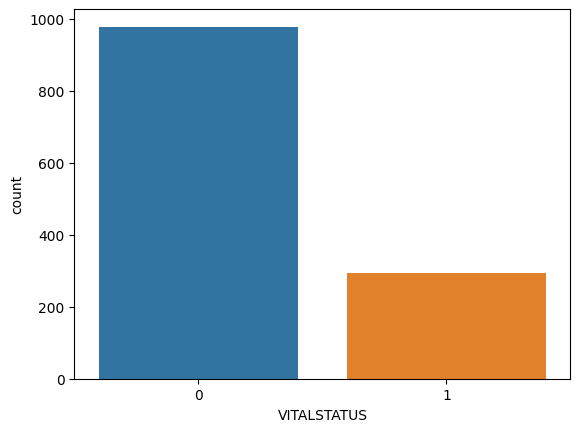

In [84]:
# ratio of censoring
sns.countplot(x='VITALSTATUS',data=df_cox)

In [100]:
df_test=df_cox[df_cox.index.isin(X_test.index)]
df_train=df_cox.drop(df_test.index)
df_val=df_train.sample(frac=0.25) # 0.2 had been dropped due to selection of test set, to obtain the ratio of 0.6/0.2/0.2, should be 0.2/0.8=0.25
df_train=df_train.drop(df_val.index)

In [101]:
print(len(df_val))

254


In [102]:
# ratio of censoring
# val=sns.countplot(x='VITALSTATUS',data=df_val)

In [103]:
print(len(df_test))

255


In [104]:
# ratio of censoring
# test=sns.countplot(x='VITALSTATUS',data=df_test)

In [105]:
print(len(df_train))

762


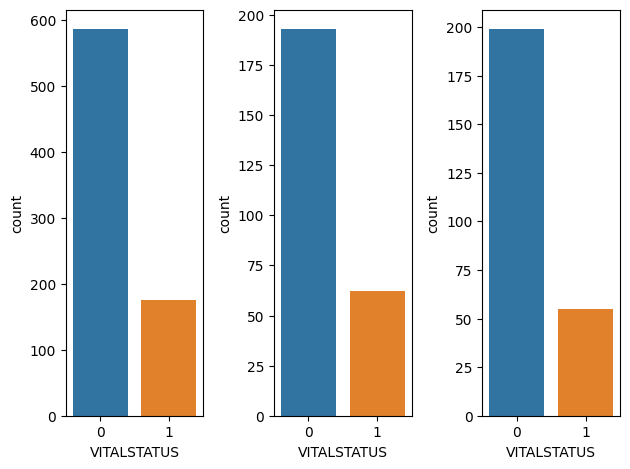

In [106]:
# ratio of censoring
# train=sns.countplot(x='VITALSTATUS',data=df_train)
fig=plt.figure()
ax1=fig.add_subplot(131)
ax1=sns.countplot(x='VITALSTATUS',data=df_train)
ax2=fig.add_subplot(132)
ax2=sns.countplot(x='VITALSTATUS',data=df_test)
ax3=fig.add_subplot(133)
ax3=sns.countplot(x='VITALSTATUS',data=df_val)
plt.tight_layout()

In [107]:
# standardize continuous feature
cols_ = ['SEX_1', 'SEX_2', 'Resection', 'Biopsy','SITE_ICD10_O2_C71', 'SITE_ICD10_O2_C72',
         'ETHNICITYNAME_ASIAN', 'ETHNICITYNAME_BLACK', 'ETHNICITYNAME_Ethnicity NOS',
         'ETHNICITYNAME_WHITE', 'GRADE_G2', 'GRADE_G3', 'GRADE_NOS', 'palliative_RT_0',
         'palliative_RT_1', 'curative_RT_0', 'curative_RT_1', 'SITE_ICD10_O2_C71', 'SITE_ICD10_O2_C72',
         'TMZ-Palliative_0', 'TMZ-Palliative_1', 'TMZ-Curative_0', 'TMZ-Curative_1', 'PCV-Palliative_0',
         'PCV-Palliative_1', 'PCV-Curative_0', 'PCV-Curative_1']
cols_std = ['AGE', 'BIGTUMOURCOUNT']

standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_]

x_mapper = DataFrameMapper(standardize+leave)
# re-ranking and standardize
# for val and test, don't fit, only standardize
x_train=x_mapper.fit_transform(df_train).astype('float32')
x_val=x_mapper.transform(df_val).astype('float32')
x_test=x_mapper.transform(df_test).astype('float32')

num_durations=10
# discretize coninuous (duration, events) pairs based on a set of points
labtrans=DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['INTERVAL_DIAG_TO_VS'].values, df['VITALSTATUS'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train=(x_train, y_train)
val=(x_val, y_val)

durations_test, events_test = get_target(df_test)

# DeepHit starting with 1 layer 32 nodes

/opt/python/3.10.9/lib/python3.10/site-packages/torchtuples/callbacks.py:607: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)



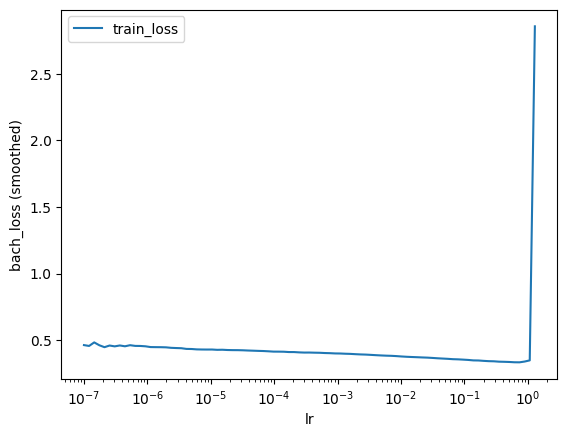

In [108]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[32]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH32=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
batch_size=256
lr_finder = DH32.lr_finder(x_train,y_train,batch_size,tolerance=3)
_ = lr_finder.plot()

In [146]:
lr_finder.get_best_lr()

0.02420128264794396

In [150]:
DH32.optimizer.set_lr(0.0242)
epochs=256
callbacks=[tt.callbacks.EarlyStopping()]
log=DH32.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val) # 

30:	[0s / 0s],		train_loss: 0.2348,	val_loss: 0.2751
31:	[0s / 0s],		train_loss: 0.2356,	val_loss: 0.2754
32:	[0s / 0s],		train_loss: 0.2357,	val_loss: 0.2771
33:	[0s / 0s],		train_loss: 0.2336,	val_loss: 0.2790
34:	[0s / 0s],		train_loss: 0.2255,	val_loss: 0.2814
35:	[0s / 0s],		train_loss: 0.2308,	val_loss: 0.2809
36:	[0s / 0s],		train_loss: 0.2284,	val_loss: 0.2810
37:	[0s / 0s],		train_loss: 0.2282,	val_loss: 0.2799
38:	[0s / 0s],		train_loss: 0.2343,	val_loss: 0.2785
39:	[0s / 0s],		train_loss: 0.2323,	val_loss: 0.2782
40:	[0s / 0s],		train_loss: 0.2265,	val_loss: 0.2783


## Eval your mdoel

antolini C index 0.7283436027546213
integrated BS 0.13378447263797225


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



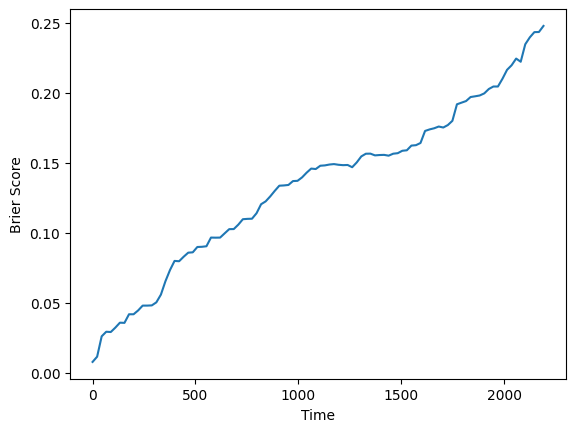

In [151]:
# predict the survival function for 10 samples
surv=DH32.interpolate(10).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time')
print('integrated BS',EV.integrated_brier_score(time_grid))

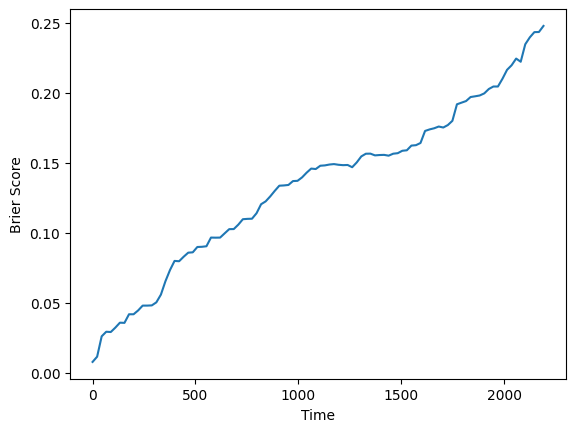

In [152]:
# time_grid=np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time')

## 1 layer 64 nodes DH

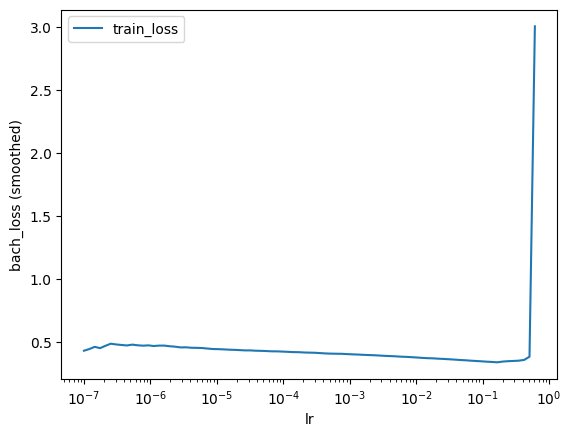

In [153]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[64]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH64=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH64.lr_finder(x_train,y_train,batch_size,tolerance=3) # search for learning rate
_ = lr_finder.plot()

In [154]:
lr_finder.get_best_lr()

0.016681005372000682

In [155]:
DH64.optimizer.set_lr(0.035)
epochs=100
callbacks=[tt.callbacks.EarlyStopping(patience=10)]
log=DH64.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val) # 

0:	[0s / 0s],		train_loss: 0.4609,	val_loss: 0.3258
1:	[0s / 0s],		train_loss: 0.3676,	val_loss: 0.3026
2:	[0s / 0s],		train_loss: 0.3151,	val_loss: 0.2990
3:	[0s / 0s],		train_loss: 0.2914,	val_loss: 0.3077
4:	[0s / 0s],		train_loss: 0.2733,	val_loss: 0.3108
5:	[0s / 0s],		train_loss: 0.2505,	val_loss: 0.3091
6:	[0s / 0s],		train_loss: 0.2596,	val_loss: 0.3108
7:	[0s / 0s],		train_loss: 0.2501,	val_loss: 0.3024
8:	[0s / 0s],		train_loss: 0.2406,	val_loss: 0.2994
9:	[0s / 0s],		train_loss: 0.2345,	val_loss: 0.3025
10:	[0s / 0s],		train_loss: 0.2258,	val_loss: 0.3102
11:	[0s / 0s],		train_loss: 0.2193,	val_loss: 0.3202
12:	[0s / 0s],		train_loss: 0.2180,	val_loss: 0.3293


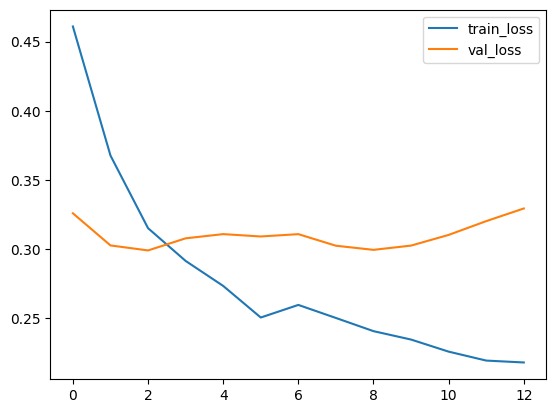

In [156]:
_ = log.plot()

antolini C index 0.684215295396883
integrated BS 0.18101277074896213


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



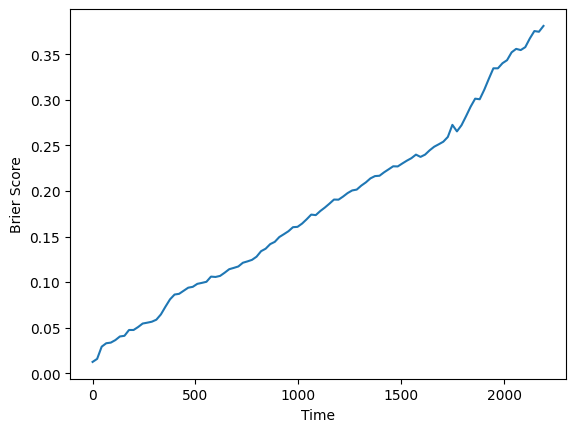

In [157]:
surv=DH64.interpolate(10).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time')
print('integrated BS',EV.integrated_brier_score(time_grid))

In [158]:
EV.integrated_brier_score(time_grid)

0.18101277074896213

## DeepHit 2 layers 32/64/128 nodes

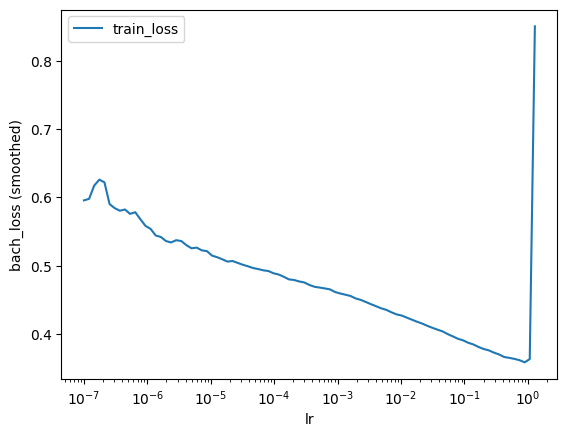

In [159]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[32, 32]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH232=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH232.lr_finder(x_train,y_train,batch_size,tolerance=3) # search for learning rate
_ = lr_finder.plot()

In [160]:
lr_finder.get_best_lr()

0.08902150854450441

In [161]:
DH232.optimizer.set_lr(0.035)
epochs=256
callbacks=[tt.callbacks.EarlyStopping(patience=10)]
log=DH232.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val) # ,val_data=val

0:	[0s / 0s],		train_loss: 0.8476,	val_loss: 0.3407
1:	[0s / 0s],		train_loss: 0.5694,	val_loss: 0.3515
2:	[0s / 0s],		train_loss: 0.4124,	val_loss: 0.3438
3:	[0s / 0s],		train_loss: 0.3583,	val_loss: 0.3358
4:	[0s / 0s],		train_loss: 0.3375,	val_loss: 0.3399
5:	[0s / 0s],		train_loss: 0.3331,	val_loss: 0.3364
6:	[0s / 0s],		train_loss: 0.3311,	val_loss: 0.3354
7:	[0s / 0s],		train_loss: 0.3119,	val_loss: 0.3240
8:	[0s / 0s],		train_loss: 0.3034,	val_loss: 0.3241
9:	[0s / 0s],		train_loss: 0.2991,	val_loss: 0.3214
10:	[0s / 0s],		train_loss: 0.2931,	val_loss: 0.3187
11:	[0s / 0s],		train_loss: 0.2905,	val_loss: 0.3161
12:	[0s / 0s],		train_loss: 0.2793,	val_loss: 0.3151
13:	[0s / 0s],		train_loss: 0.2801,	val_loss: 0.3148
14:	[0s / 0s],		train_loss: 0.2745,	val_loss: 0.3146
15:	[0s / 0s],		train_loss: 0.2773,	val_loss: 0.3162
16:	[0s / 0s],		train_loss: 0.2717,	val_loss: 0.3180
17:	[0s / 0s],		train_loss: 0.2674,	val_loss: 0.3175
18:	[0s / 0s],		train_loss: 0.2650,	val_loss: 0.3168
19:

antolini C index 0.7331460674157303
integrated BS 0.18508636485580965


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



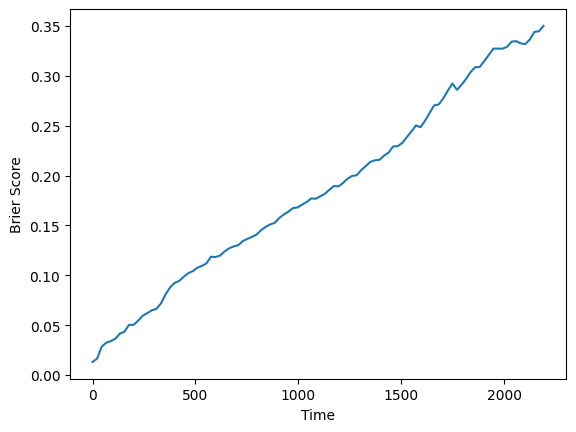

In [162]:
surv=DH232.interpolate(10).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time')
print('integrated BS',EV.integrated_brier_score(time_grid))

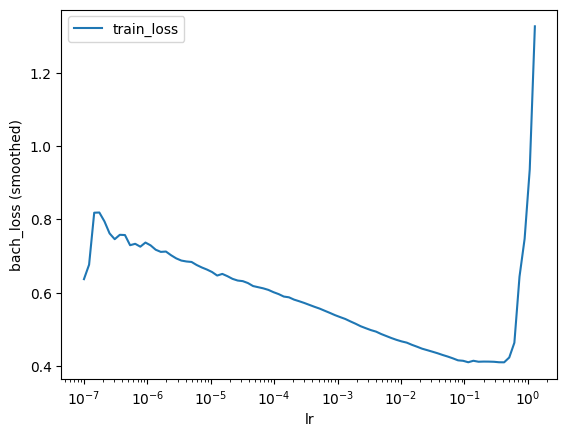

In [163]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[128, 128]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH2128=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH2128.lr_finder(x_train,y_train,batch_size,tolerance=10) # search for learning rate
_ = lr_finder.plot()

In [164]:
lr_finder.get_best_lr()

0.04229242874389523

In [165]:
DH2128.optimizer.set_lr(0.02)
epochs=128
callbacks=[tt.callbacks.EarlyStopping(patience=10)]
log=DH2128.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val)

0:	[0s / 0s],		train_loss: 0.7616,	val_loss: 0.3193
1:	[0s / 0s],		train_loss: 0.5506,	val_loss: 0.3704
2:	[0s / 0s],		train_loss: 0.5037,	val_loss: 0.3467
3:	[0s / 0s],		train_loss: 0.4008,	val_loss: 0.3325
4:	[0s / 0s],		train_loss: 0.3587,	val_loss: 0.3377
5:	[0s / 0s],		train_loss: 0.3278,	val_loss: 0.3365
6:	[0s / 0s],		train_loss: 0.3152,	val_loss: 0.3374
7:	[0s / 0s],		train_loss: 0.3091,	val_loss: 0.3527
8:	[0s / 0s],		train_loss: 0.2921,	val_loss: 0.3655
9:	[0s / 0s],		train_loss: 0.2974,	val_loss: 0.3447
10:	[0s / 0s],		train_loss: 0.2597,	val_loss: 0.3352


antolini C index 0.6586625588981515
integrated BS 0.19309855619976266


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



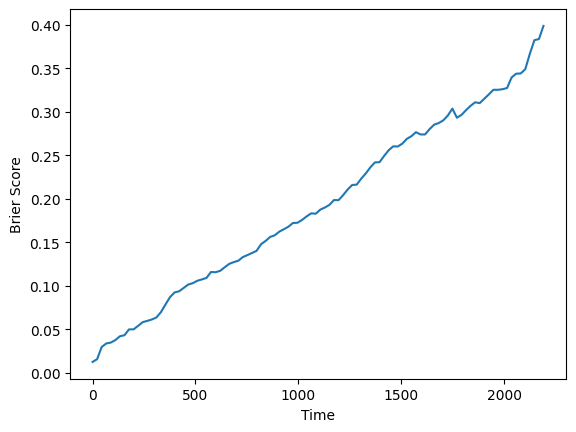

In [166]:
surv=DH2128.interpolate(10).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time')
print('integrated BS',EV.integrated_brier_score(time_grid))

## DeepHit 3layers 64/128/256 nodes 

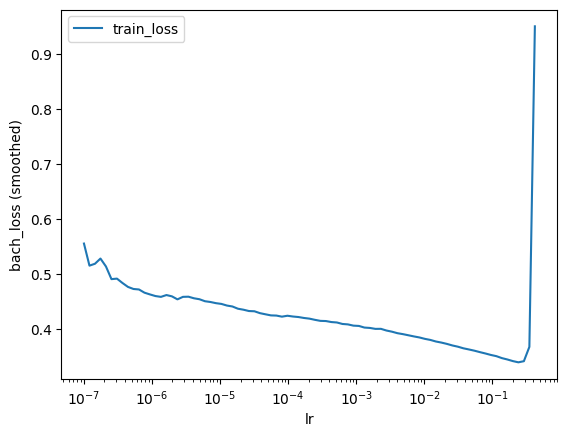

In [167]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[64,64,64]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH364=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH364.lr_finder(x_train,y_train,batch_size,tolerance=5) # search for learning rate
_ = lr_finder.plot()

In [168]:
lr_finder.get_best_lr()

0.02420128264794396

In [170]:
DH364.optimizer.set_lr(0.0242)
epochs=256
callbacks=[tt.callbacks.EarlyStopping(patience=10)]
log=DH364.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val) # 

14:	[0s / 0s],		train_loss: 0.3656,	val_loss: 0.3361
15:	[0s / 0s],		train_loss: 0.3222,	val_loss: 0.3568
16:	[0s / 0s],		train_loss: 0.3088,	val_loss: 0.3866
17:	[0s / 0s],		train_loss: 0.3050,	val_loss: 0.3883
18:	[0s / 0s],		train_loss: 0.2770,	val_loss: 0.3851
19:	[0s / 0s],		train_loss: 0.2862,	val_loss: 0.3692
20:	[0s / 0s],		train_loss: 0.2589,	val_loss: 0.3748
21:	[0s / 0s],		train_loss: 0.2633,	val_loss: 0.3883
22:	[0s / 0s],		train_loss: 0.2624,	val_loss: 0.4096
23:	[0s / 0s],		train_loss: 0.2533,	val_loss: 0.4281
24:	[0s / 0s],		train_loss: 0.2565,	val_loss: 0.4416


Text(0.5, 1.0, 'DeepHit 3lyaers 64nodes training log')

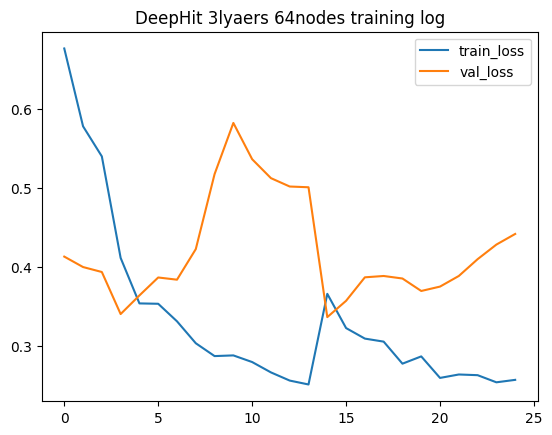

In [171]:
_ = log.plot()
plt.title('DeepHit 3lyaers 64nodes training log')

antolini C index 0.7323305545487495
integrated BS 0.18029464074384868


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



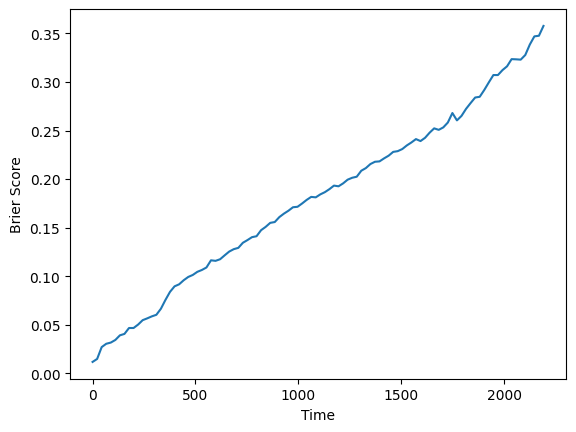

In [172]:
surv=DH364.interpolate(10).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time')
print('integrated BS',EV.integrated_brier_score(time_grid))

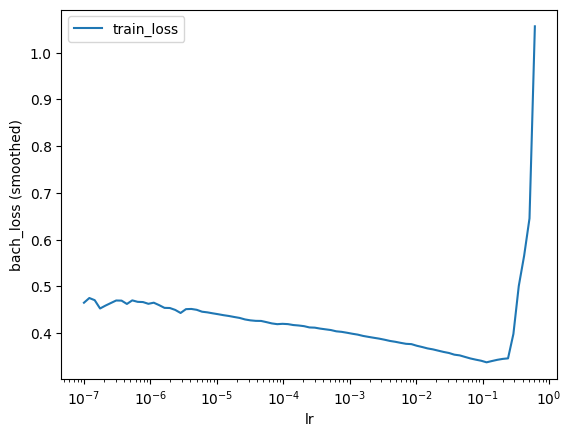

In [838]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[128,128,128]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH3128=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH3128.lr_finder(x_train,y_train,batch_size,tolerance=10) # search for learning rate
_ = lr_finder.plot()

In [839]:
lr_finder.get_best_lr()

0.01149756995397742

In [841]:
DH3128.optimizer.set_lr(0.0115)
epochs=256
callbacks=[tt.callbacks.EarlyStopping(patience=10)]
log=DH3128.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val) #

30:	[0s / 0s],		train_loss: 0.2524,	val_loss: 0.3096
31:	[0s / 0s],		train_loss: 0.2482,	val_loss: 0.3075
32:	[0s / 0s],		train_loss: 0.2379,	val_loss: 0.3063
33:	[0s / 0s],		train_loss: 0.2628,	val_loss: 0.3072
34:	[0s / 0s],		train_loss: 0.2499,	val_loss: 0.3091
35:	[0s / 0s],		train_loss: 0.2310,	val_loss: 0.3123
36:	[0s / 0s],		train_loss: 0.2331,	val_loss: 0.3181
37:	[0s / 0s],		train_loss: 0.2373,	val_loss: 0.3242
38:	[0s / 0s],		train_loss: 0.2237,	val_loss: 0.3317
39:	[0s / 0s],		train_loss: 0.2306,	val_loss: 0.3375
40:	[0s / 0s],		train_loss: 0.2289,	val_loss: 0.3448
41:	[0s / 0s],		train_loss: 0.2277,	val_loss: 0.3470
42:	[0s / 0s],		train_loss: 0.2280,	val_loss: 0.3514


Text(0.5, 1.0, 'DeepHit 3 layers 128 nodes')

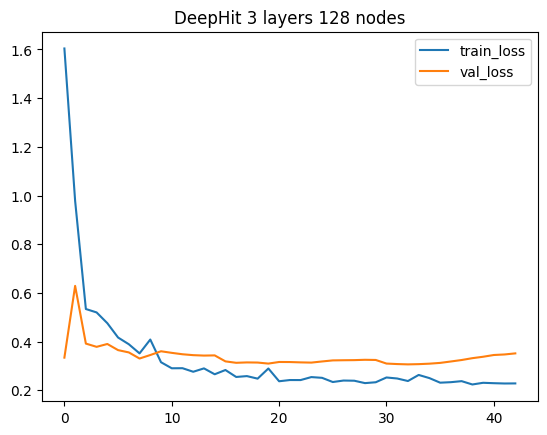

In [842]:
_ = log.plot()
plt.title('DeepHit 3 layers 128 nodes')

antolini C index 0.7125770206596593
integrated BS 0.15396909916514107


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



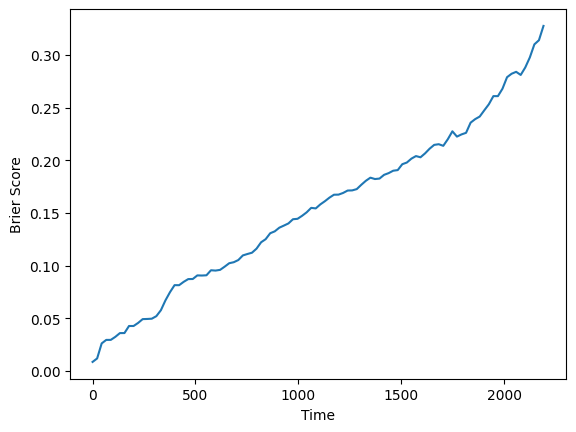

In [843]:
surv=DH3128.interpolate(10).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time')
print('integrated BS',EV.integrated_brier_score(time_grid))

## DeepHit 4layers 32/64/128nodes

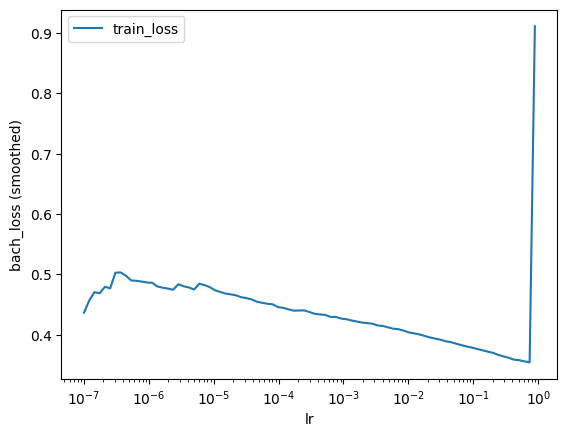

In [109]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[32,32,32,32]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH432=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH432.lr_finder(x_train,y_train,batch_size,tolerance=5) # search for learning rate
_ = lr_finder.plot()

In [110]:
lr_finder.get_best_lr()

0.07390722033525823

In [113]:
DH432.optimizer.set_lr(0.074)
epochs=512
callbacks=[tt.callbacks.EarlyStopping()]
log=DH432.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val)

44:	[0s / 0s],		train_loss: 0.2637,	val_loss: 0.2407
45:	[0s / 0s],		train_loss: 0.2619,	val_loss: 0.2409
46:	[0s / 0s],		train_loss: 0.2621,	val_loss: 0.2411
47:	[0s / 0s],		train_loss: 0.2532,	val_loss: 0.2419
48:	[0s / 0s],		train_loss: 0.2580,	val_loss: 0.2428
49:	[0s / 0s],		train_loss: 0.2544,	val_loss: 0.2433
50:	[0s / 0s],		train_loss: 0.2524,	val_loss: 0.2439
51:	[0s / 0s],		train_loss: 0.2581,	val_loss: 0.2446
52:	[0s / 0s],		train_loss: 0.2606,	val_loss: 0.2447
53:	[0s / 0s],		train_loss: 0.2534,	val_loss: 0.2448
54:	[0s / 0s],		train_loss: 0.2571,	val_loss: 0.2452


Text(0.5, 0, 'epochs')

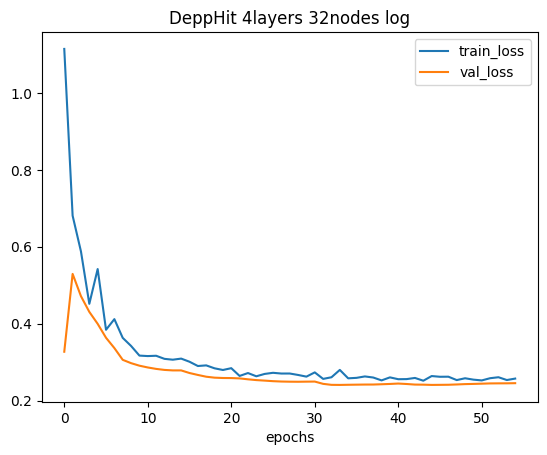

In [114]:
_ = log.plot()
plt.title('DeppHit 4layers 32nodes log')
plt.xlabel('epochs')

/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



antolini C index 0.748459586806814
integrated BS 0.13395027110745814


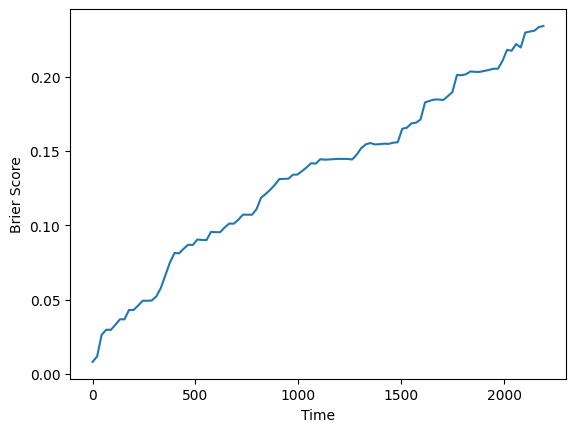

In [115]:
surv=DH432.interpolate(10).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time')
print('integrated BS',EV.integrated_brier_score(time_grid))

## so far the best one is 4 layers 64 nodes

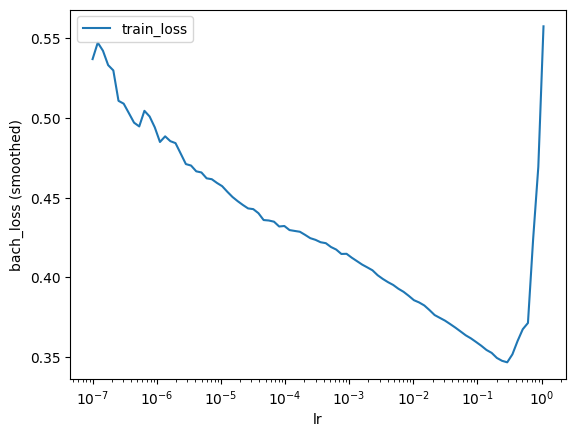

In [173]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[64,64,64,64]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH464=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH464.lr_finder(x_train,y_train,batch_size,tolerance=3) # search for learning rate
_ = lr_finder.plot()

In [174]:
lr_finder.get_best_lr()

0.029150530628251937

In [175]:
DH464.optimizer.set_lr(0.029)
epochs=256
callbacks=[tt.callbacks.EarlyStopping(patience=3)]
log=DH464.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val)

0:	[0s / 0s],		train_loss: 0.5140,	val_loss: 0.3200
1:	[0s / 0s],		train_loss: 0.3675,	val_loss: 0.3375
2:	[0s / 0s],		train_loss: 0.3520,	val_loss: 0.3332
3:	[0s / 0s],		train_loss: 0.3792,	val_loss: 0.3205


Text(0.5, 0, 'epochs')

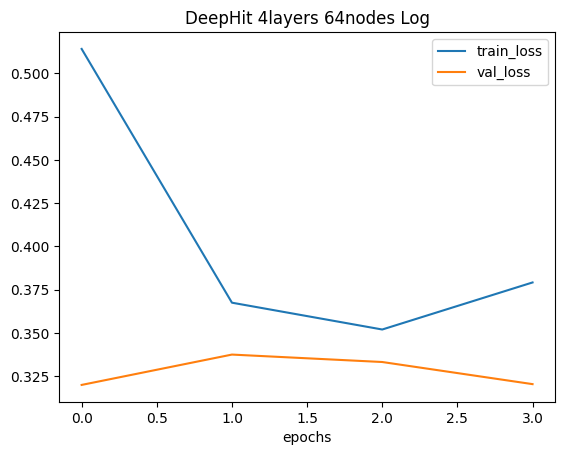

In [176]:
_ = log.plot()
plt.title('DeepHit 4layers 64nodes Log')
plt.xlabel('epochs')

antolini C index 0.6396339253352664
integrated BS 0.21405117855221614


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



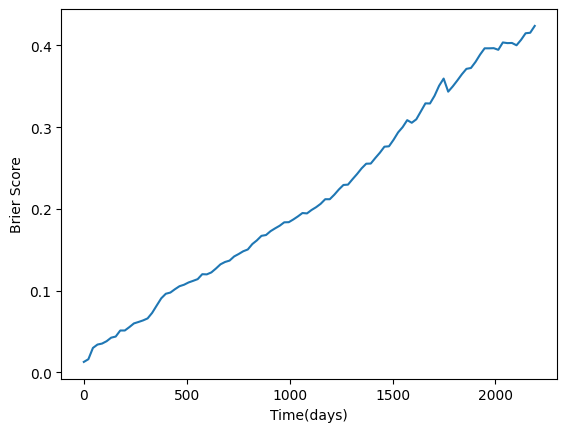

In [177]:
surv=DH464.interpolate(10).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time(days)')
print('integrated BS',EV.integrated_brier_score(time_grid))

## Generate single patient's prediction (not so accurate actually, since most oligo patients had more than 10 years' OS)

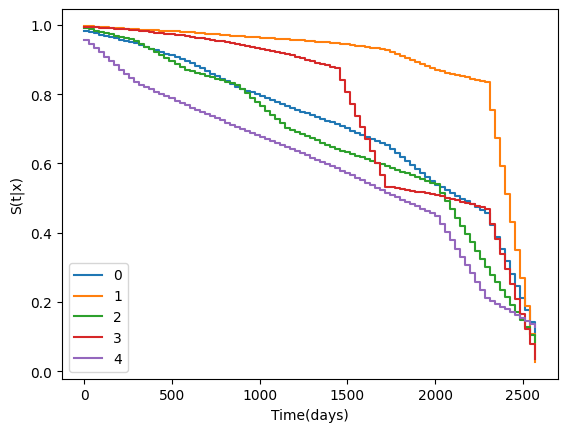

In [1054]:
surv.iloc[:,:5].plot(drawstyle='steps-post')
plt.title()
plt.ylabel('S(t|x)')
_ = plt.xlabel('Time(days)')

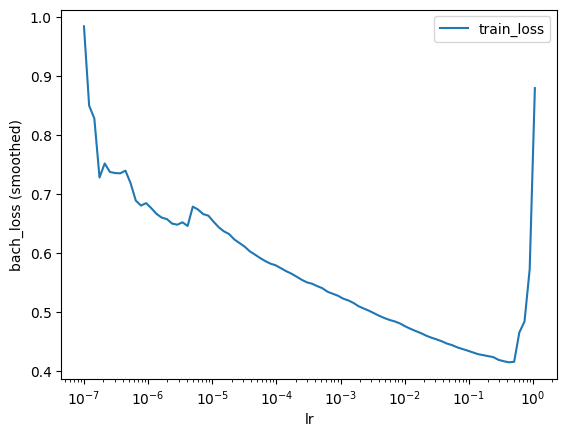

In [892]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[128,128,128,128]
batch_norm=True
dropout=0.5
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH4128=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH4128.lr_finder(x_train,y_train,batch_size,tolerance=5) # search for learning rate
_ = lr_finder.plot()

In [893]:
lr_finder.get_best_lr()

0.04229242874389523

In [901]:
DH4128.optimizer.set_lr(0.0423)
epochs=1024
callbacks=[tt.callbacks.EarlyStopping(patience=25)]
log=DH4128.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val)

216:	[0s / 0s],		train_loss: 0.2366,	val_loss: 0.2396
217:	[0s / 0s],		train_loss: 0.2399,	val_loss: 0.2395
218:	[0s / 0s],		train_loss: 0.2443,	val_loss: 0.2393
219:	[0s / 0s],		train_loss: 0.2396,	val_loss: 0.2393
220:	[0s / 0s],		train_loss: 0.2367,	val_loss: 0.2391
221:	[0s / 0s],		train_loss: 0.2497,	val_loss: 0.2394
222:	[0s / 0s],		train_loss: 0.2538,	val_loss: 0.2399
223:	[0s / 0s],		train_loss: 0.2393,	val_loss: 0.2403
224:	[0s / 0s],		train_loss: 0.2294,	val_loss: 0.2405
225:	[0s / 0s],		train_loss: 0.2400,	val_loss: 0.2406
226:	[0s / 0s],		train_loss: 0.2402,	val_loss: 0.2408
227:	[0s / 0s],		train_loss: 0.2367,	val_loss: 0.2411
228:	[0s / 0s],		train_loss: 0.2423,	val_loss: 0.2410
229:	[0s / 0s],		train_loss: 0.2405,	val_loss: 0.2410
230:	[0s / 0s],		train_loss: 0.2329,	val_loss: 0.2408
231:	[0s / 0s],		train_loss: 0.2389,	val_loss: 0.2407
232:	[0s / 0s],		train_loss: 0.2335,	val_loss: 0.2407
233:	[0s / 0s],		train_loss: 0.2347,	val_loss: 0.2404
234:	[0s / 0s],		train_loss:

antolini C index 0.7485501993475897
integrated BS 0.1308895288915396


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



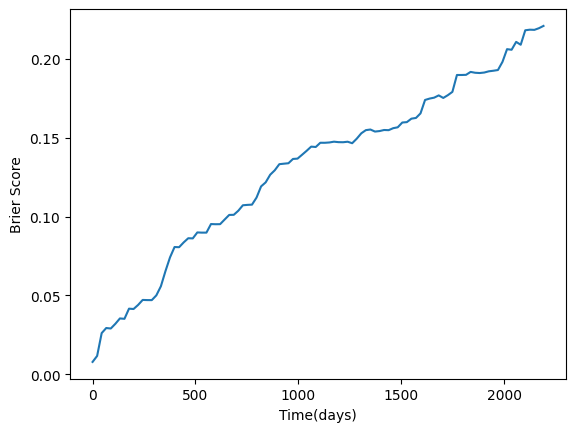

In [902]:
surv=DH4128.interpolate(100).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time(days)')
print('integrated BS',EV.integrated_brier_score(time_grid))

Text(0.5, 0, 'epochs')

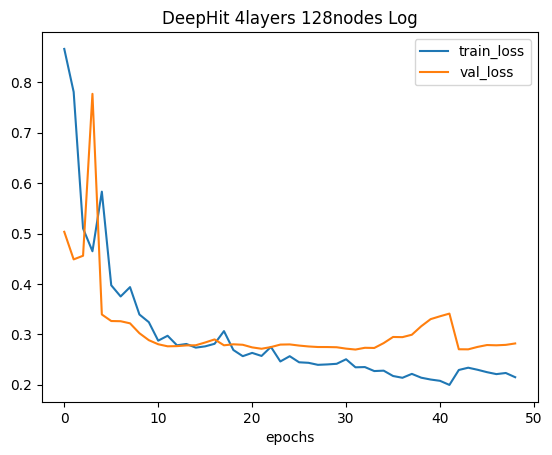

In [875]:
_ = log.plot()
plt.title('DeepHit 4layers 128nodes Log')
plt.xlabel('epochs')

## DeepHit 5 layers

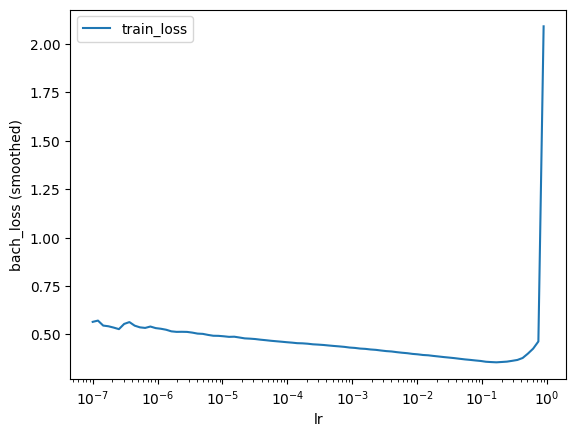

In [1055]:
in_features = x_train.shape[1]
out_features=labtrans.out_features
num_nodes=[64,64,64,64,64]
batch_norm=True
dropout=0.2
# base MLP
net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

optimizer=tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)
DH5128=DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

batch_size=256
lr_finder = DH5128.lr_finder(x_train,y_train,batch_size,tolerance=3) # search for learning rate
_ = lr_finder.plot()

In [1056]:
lrfind.get_best_lr()

0.0613590727341321

In [1058]:
DH5128.optimizer.set_lr(0.0614)
epochs=1024
callbacks=[tt.callbacks.EarlyStopping(patience=10)]
log=DH5128.fit(x_train,y_train,batch_size,epochs,callbacks,val_data=val)

36:	[0s / 0s],		train_loss: 0.3086,	val_loss: 0.3511
37:	[0s / 0s],		train_loss: 0.3089,	val_loss: 0.3553
38:	[0s / 0s],		train_loss: 0.2966,	val_loss: 0.3571
39:	[0s / 0s],		train_loss: 0.2935,	val_loss: 0.3550
40:	[0s / 0s],		train_loss: 0.2873,	val_loss: 0.3532
41:	[0s / 0s],		train_loss: 0.2766,	val_loss: 0.3514
42:	[0s / 0s],		train_loss: 0.2710,	val_loss: 0.3528
43:	[0s / 0s],		train_loss: 0.2765,	val_loss: 0.3504
44:	[0s / 0s],		train_loss: 0.2863,	val_loss: 0.3431
45:	[0s / 0s],		train_loss: 0.2771,	val_loss: 0.3351
46:	[0s / 0s],		train_loss: 0.2714,	val_loss: 0.3342
47:	[0s / 0s],		train_loss: 0.2640,	val_loss: 0.3345
48:	[0s / 0s],		train_loss: 0.2638,	val_loss: 0.3347
49:	[0s / 0s],		train_loss: 0.2644,	val_loss: 0.3366
50:	[0s / 0s],		train_loss: 0.2647,	val_loss: 0.3330
51:	[0s / 0s],		train_loss: 0.2678,	val_loss: 0.3331
52:	[0s / 0s],		train_loss: 0.2617,	val_loss: 0.3329
53:	[0s / 0s],		train_loss: 0.2551,	val_loss: 0.3300
54:	[0s / 0s],		train_loss: 0.2644,	val_loss: 

antolini C index 0.7572490032620515
integrated BS 0.13419196024904725


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



Text(0.5, 0, 'epochs')

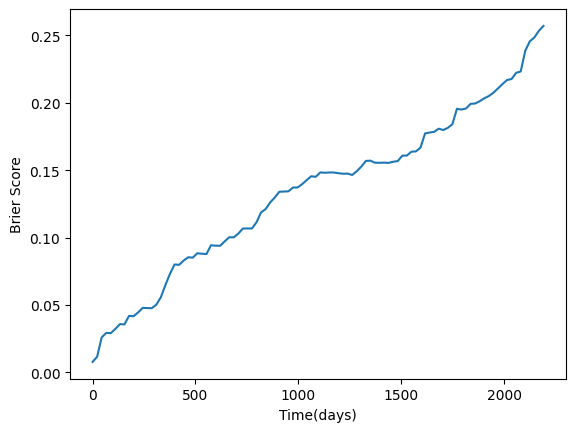

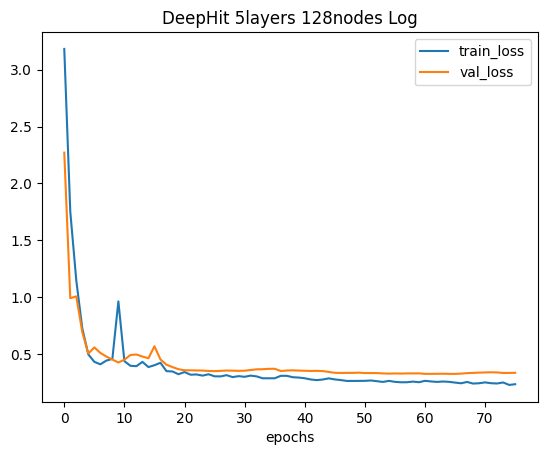

In [1059]:
surv=DH5128.interpolate(100).predict_surv_df(x_test)
EV=EvalSurv(surv,durations_test, events_test, censor_surv='km')
print('antolini C index',EV.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
EV.brier_score(time_grid).plot()
plt.ylabel('Brier Score')
_ = plt.xlabel('Time(days)')
print('integrated BS',EV.integrated_brier_score(time_grid))
_ = log.plot()
plt.title('DeepHit 5layers 128nodes Log')
plt.xlabel('epochs')

# DeepSurv

In [143]:
# 0.6/0.2/0.2
# df_test = df_cox.sample(frac=0.2)
# df_cox=df_cox.drop(df_test.index)
# df_val = df_cox.sample(frac=0.2)
# df_cox=df_cox.drop(df_val.index)

In [911]:
# standardize continuous feature
cols_ = ['SEX_1', 'SEX_2', 'Resection', 'Biopsy','SITE_ICD10_O2_C71', 'SITE_ICD10_O2_C72',
         'ETHNICITYNAME_ASIAN', 'ETHNICITYNAME_BLACK', 'ETHNICITYNAME_Ethnicity NOS',
         'ETHNICITYNAME_WHITE', 'GRADE_G2', 'GRADE_G3', 'GRADE_NOS', 'palliative_RT_0',
         'palliative_RT_1', 'curative_RT_0', 'curative_RT_1', 'SITE_ICD10_O2_C71', 'SITE_ICD10_O2_C72',
         'TMZ-Palliative_0', 'TMZ-Palliative_1', 'TMZ-Curative_0', 'TMZ-Curative_1', 'PCV-Palliative_0',
         'PCV-Palliative_1', 'PCV-Curative_0', 'PCV-Curative_1']
cols_std = ['AGE', 'BIGTUMOURCOUNT']

standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_]

x_mapper = DataFrameMapper(standardize+leave)

x_train=x_mapper.fit_transform(df_train).astype('float32')
x_val=x_mapper.transform(df_val).astype('float32')
x_test=x_mapper.transform(df_test).astype('float32')

get_target = lambda df: (df['INTERVAL_DIAG_TO_VS'].values, df['VITALSTATUS'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val



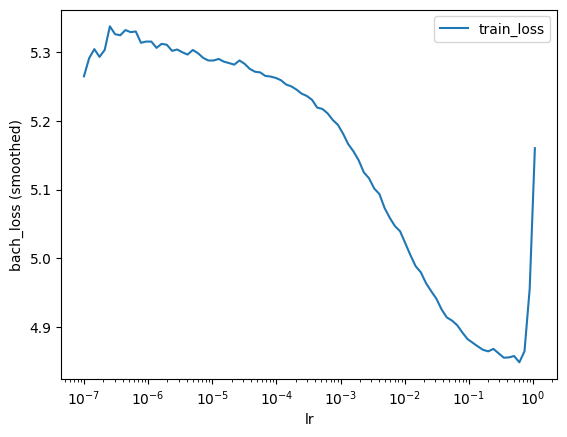

In [920]:
in_features=x_train.shape[1]
num_nodes=[128,128]
out_features=1
batch_norm=True
dropout=0.2
output_bias=False

net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)


optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)


DS2128=CoxPH(net, optimizer) # same net and optimizer as DeepHit

batch_size = 256
lrfind=DS2128.lr_finder(x_train,y_train,batch_size,tolerance=10) # only thing diff here is tolerance
_ = lrfind.plot()


In [921]:
lrfind.get_best_lr()

0.0613590727341321

In [926]:
DS2128.optimizer.set_lr(0.0614)
epochs=256
callbacks=[tt.callbacks.EarlyStopping(patience=20)]
verbose=True
log=DS2128.fit(x_train,y_train,batch_size,epochs,callbacks,verbose,val_data=val,val_batch_size=batch_size) # 

89:	[0s / 0s],		train_loss: 4.2250,	val_loss: 4.6156
90:	[0s / 0s],		train_loss: 4.1212,	val_loss: 4.6104
91:	[0s / 0s],		train_loss: 4.1428,	val_loss: 4.6298
92:	[0s / 0s],		train_loss: 4.1104,	val_loss: 4.6224
93:	[0s / 0s],		train_loss: 4.1200,	val_loss: 4.6061
94:	[0s / 0s],		train_loss: 4.0698,	val_loss: 4.6132
95:	[0s / 0s],		train_loss: 4.0287,	val_loss: 4.6483
96:	[0s / 0s],		train_loss: 4.0468,	val_loss: 4.6659
97:	[0s / 0s],		train_loss: 4.0496,	val_loss: 4.6640
98:	[0s / 0s],		train_loss: 3.9431,	val_loss: 4.6673
99:	[0s / 0s],		train_loss: 4.2551,	val_loss: 4.6834
100:	[0s / 0s],		train_loss: 3.9318,	val_loss: 4.6871
101:	[0s / 0s],		train_loss: 3.9487,	val_loss: 4.7281
102:	[0s / 0s],		train_loss: 3.9856,	val_loss: 4.7427
103:	[0s / 0s],		train_loss: 3.9431,	val_loss: 4.7597
104:	[0s / 0s],		train_loss: 3.9346,	val_loss: 4.7556
105:	[0s / 0s],		train_loss: 3.9709,	val_loss: 4.7598
106:	[0s / 0s],		train_loss: 3.9135,	val_loss: 4.7806
107:	[0s / 0s],		train_loss: 3.8850,	va

antolini C index 0.7501812250815513
integrated BS 0.1284774873707515


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



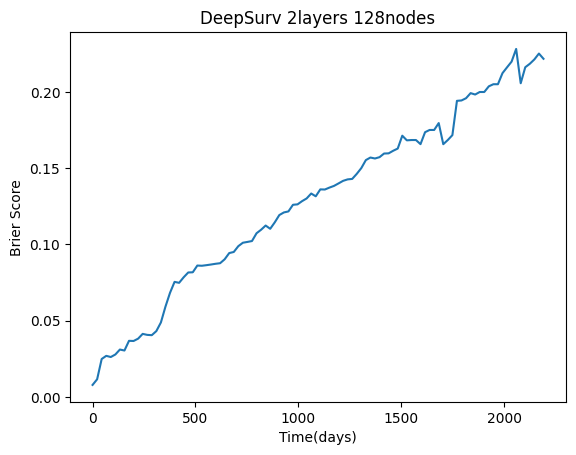

In [930]:
hazard=DS2128.compute_baseline_hazards()
surv=DS2128.predict_surv_df(x_test)
ev=EvalSurv(surv,durations_test,events_test,censor_surv='km')
print('antolini C index',ev.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
ev.brier_score(time_grid).plot()
plt.title('DeepSurv 2layers 128nodes')
plt.ylabel('Brier Score')
_ = plt.xlabel('Time(days)')
print('integrated BS',ev.integrated_brier_score(time_grid))

Text(0.5, 0, 'epochs')

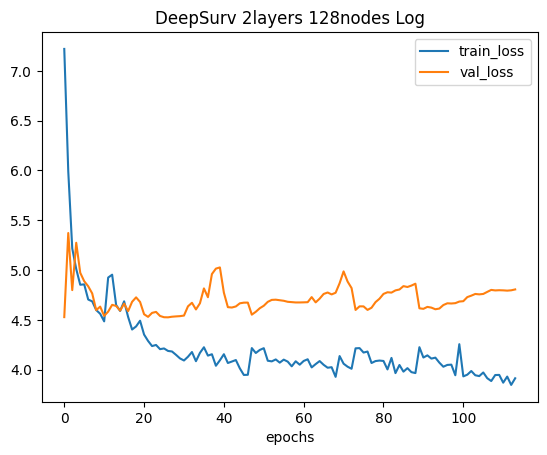

In [931]:
_ = log.plot()
plt.title('DeepSurv 2layers 128nodes Log')
plt.xlabel('epochs')

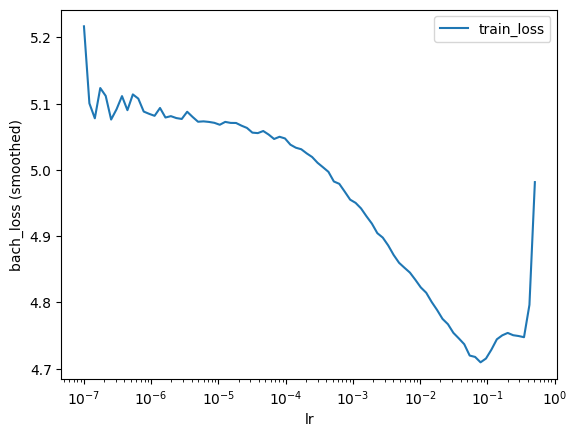

In [968]:
in_features=x_train.shape[1]
num_nodes=[256,256,256]
out_features=1
batch_norm=True
dropout=0.2
output_bias=False

net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)


optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)

DS3256=CoxPH(net, optimizer) # same net and optimizer as DeepHit

batch_size = 256
lrfind=DS3256.lr_finder(x_train,y_train,batch_size,tolerance=10) # only thing diff here is tolerance
_ = lrfind.plot()


In [969]:
lrfind.get_best_lr()

0.007924828983539215

In [973]:
DS3256.optimizer.set_lr(0.008)
epochs=256
callbacks=[tt.callbacks.EarlyStopping(patience=3)]
verbose=True
log=DS3256.fit(x_train,y_train,batch_size,epochs,callbacks,verbose,val_data=val,val_batch_size=batch_size) # 

47:	[0s / 0s],		train_loss: 4.1200,	val_loss: 4.5016
48:	[0s / 0s],		train_loss: 4.1662,	val_loss: 4.5146
49:	[0s / 0s],		train_loss: 4.0900,	val_loss: 4.5333
50:	[0s / 0s],		train_loss: 4.1287,	val_loss: 4.5532


antolini C index 0.7384015947807177
integrated BS 0.1351794197099674


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



Text(0.5, 0, 'epochs')

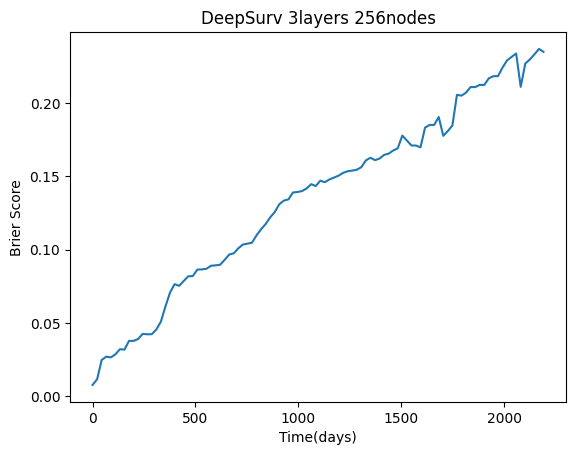

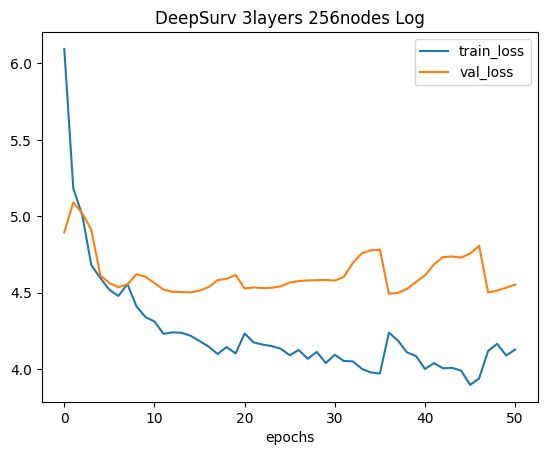

In [974]:
hazard=DS3256.compute_baseline_hazards()
surv=DS3256.predict_surv_df(x_test)
ev=EvalSurv(surv,durations_test,events_test,censor_surv='km')
print('antolini C index',ev.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
ev.brier_score(time_grid).plot()
plt.title('DeepSurv 3layers 256nodes')
plt.ylabel('Brier Score')
_ = plt.xlabel('Time(days)')
print('integrated BS',ev.integrated_brier_score(time_grid))
_ = log.plot()
plt.title('DeepSurv 3layers 256nodes Log')
plt.xlabel('epochs')

## DeepSurv 4 layers

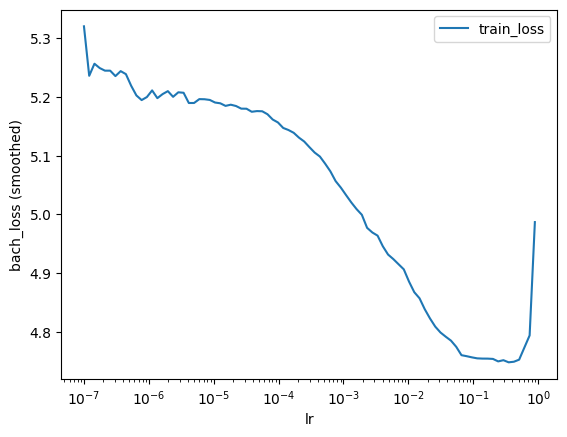

In [995]:
in_features=x_train.shape[1]
num_nodes=[256,256,256,256]
out_features=1
batch_norm=True
dropout=0.2
output_bias=False

net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)


optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)

DS4256=CoxPH(net, optimizer) # same net and optimizer as DeepHit

batch_size = 256
lrfind=DS4256.lr_finder(x_train,y_train,batch_size,tolerance=10) # only thing diff here is tolerance
_ = lrfind.plot()


In [996]:
lrfind.get_best_lr()

0.035111917342151515

In [999]:
DS4256.optimizer.set_lr(0.0351)
epochs=256
callbacks=[tt.callbacks.EarlyStopping(patience=3)]
verbose=True
log=DS4256.fit(x_train,y_train,batch_size,epochs,callbacks,verbose,val_data=val,val_batch_size=batch_size) # 

20:	[0s / 0s],		train_loss: 4.3651,	val_loss: 4.5106
21:	[0s / 0s],		train_loss: 4.4001,	val_loss: 4.5406
22:	[0s / 0s],		train_loss: 4.3378,	val_loss: 4.5829
23:	[0s / 0s],		train_loss: 4.2862,	val_loss: 4.5624


antolini C index 0.7652229068503081
integrated BS 0.1279400215001102


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



Text(0.5, 0, 'epochs')

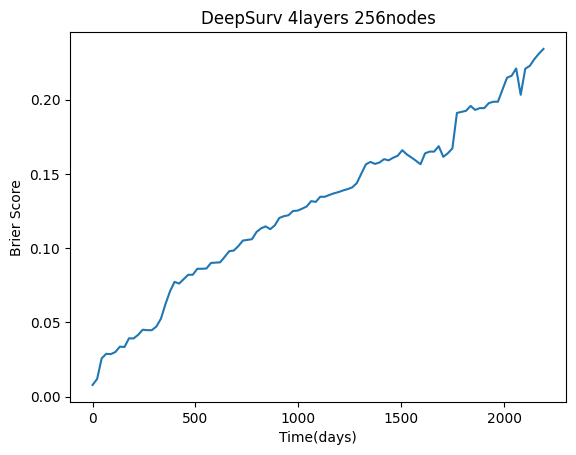

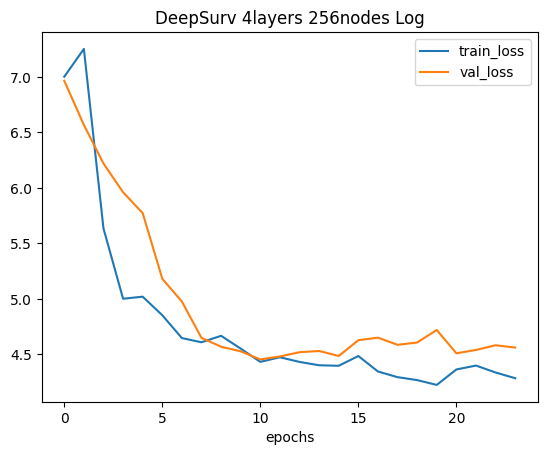

In [1000]:
hazard=DS4256.compute_baseline_hazards()
surv=DS4256.predict_surv_df(x_test)
ev=EvalSurv(surv,durations_test,events_test,censor_surv='km')
print('antolini C index',ev.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
ev.brier_score(time_grid).plot()
plt.title('DeepSurv 4layers 256nodes')
plt.ylabel('Brier Score')
_ = plt.xlabel('Time(days)')
print('integrated BS',ev.integrated_brier_score(time_grid))
_ = log.plot()
plt.title('DeepSurv 4layers 256nodes Log')
plt.xlabel('epochs')

## DeepSurv 5 layers

In [182]:
in_features=x_train.shape[1]
num_nodes=[32,32,32,32,32]
out_features=1
batch_norm=True
dropout=0.2
output_bias=False

net=tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)

optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)

DS532=CoxPH(net, optimizer) # same net and optimizer as DeepHit

batch_size = 256
lrfind=DS532.lr_finder(x_train,y_train,batch_size,tolerance=10) # only thing diff here is tolerance
_ = lrfind.plot()

TypeError: can't convert np.ndarray of type numpy.void. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [183]:
lrfind.get_best_lr()

NameError: name 'lrfind' is not defined

In [184]:
DS532.optimizer.set_lr(0.0614)
epochs=256
callbacks=[tt.callbacks.EarlyStopping(patience=3)]
verbose=True
log=DS532.fit(x_train,y_train,batch_size,epochs,callbacks,verbose,val_data=val,val_batch_size=batch_size) # 

TypeError: can't convert np.ndarray of type numpy.void. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

antolini C index 0.7471003986951794
integrated BS 0.12629831658275414


/opt/python/3.10.9/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



Text(0.5, 0, 'epochs')

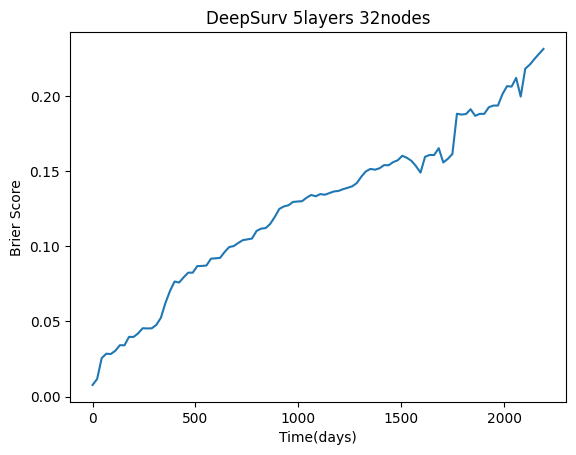

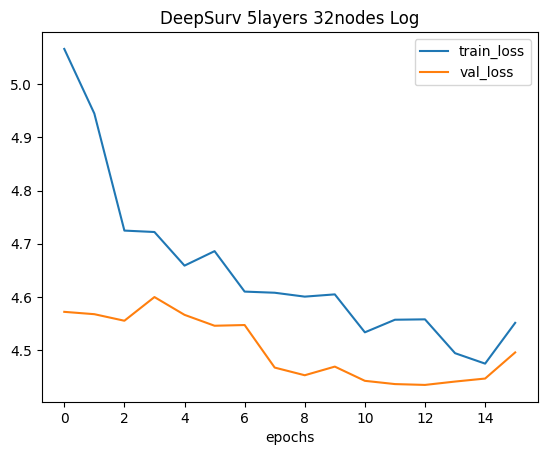

In [1020]:
hazard=DS532.compute_baseline_hazards()
surv=DS532.predict_surv_df(x_test)
ev=EvalSurv(surv,durations_test,events_test,censor_surv='km')
print('antolini C index',ev.concordance_td('antolini'))
time_grid=np.linspace(0, 2191, 100)
ev.brier_score(time_grid).plot()
plt.title('DeepSurv 5layers 32nodes')
plt.ylabel('Brier Score')
_ = plt.xlabel('Time(days)')
print('integrated BS',ev.integrated_brier_score(time_grid))
_ = log.plot()
plt.title('DeepSurv 5layers 32nodes Log')
plt.xlabel('epochs')

In [185]:
# from sklearn.model_selection import train_test_split
# from sksurv.datasets import get_x_y
# df_test=df_cox[df_cox.index.isin(X_test.index)]
# df_train=df_cox.drop(df_test.index)
# df_val=df_train.sample(frac=0.25) # 0.2 had been dropped due to selection of test set, to obtain the ratio of 0.6/0.2/0.2, should be 0.2/0.8=0.25
# df_train=df_train.drop(df_val.index)

# # standardize continuous feature
# cols_ = ['SEX_1', 'SEX_2', 'Resection', 'Biopsy','SITE_ICD10_O2_C71', 'SITE_ICD10_O2_C72',
#          'ETHNICITYNAME_ASIAN', 'ETHNICITYNAME_BLACK', 'ETHNICITYNAME_Ethnicity NOS',
#          'ETHNICITYNAME_WHITE', 'GRADE_G2', 'GRADE_G3', 'GRADE_NOS', 'palliative_RT_0',
#          'palliative_RT_1', 'curative_RT_0', 'curative_RT_1', 'SITE_ICD10_O2_C71', 'SITE_ICD10_O2_C72',
#          'TMZ-Palliative_0', 'TMZ-Palliative_1', 'TMZ-Curative_0', 'TMZ-Curative_1', 'PCV-Palliative_0',
#          'PCV-Palliative_1', 'PCV-Curative_0', 'PCV-Curative_1']
# cols_std = ['AGE', 'BIGTUMOURCOUNT']

# standardize = [([col], StandardScaler()) for col in cols_std]
# leave = [(col, None) for col in cols_]

# x_mapper = DataFrameMapper(standardize+leave)
# # re-ranking and standardize
# # for val and test, don't fit, only standardize
# x_train=x_mapper.fit_transform(df_train).astype('float32')
# x_val=x_mapper.transform(df_val).astype('float32')
# x_test=x_mapper.transform(df_test).astype('float32')
# num_durations=10
# # discretize coninuous (duration, events) pairs based on a set of points
# labtrans=DeepHitSingle.label_transform(num_durations)
# get_target = lambda df: (df['INTERVAL_DIAG_TO_VS'].values, df['VITALSTATUS'].values)
# y_train = labtrans.fit_transform(*get_target(df_train))
# y_val = labtrans.transform(*get_target(df_val))

# train=(x_train, y_train)
# val=(x_val, y_val)

# durations_test, events_test = get_target(df_test)
# # -----------------------------------------------------------------


# model = DH364

# # Use SurvLimeExplainer class to find the feature importance
# training_features = x_train
# training_events = [event for event, _ in y_train]
# training_times = [time for _, time in y_train]

# explainer = SurvLimeExplainer(
#     training_features=training_features,
#     training_events=training_events,
#     training_times=training_times,
#     model_output_times=model.event_times_,
# )

# # explanation variable will have the computed SurvLIME values
# explanation = explainer.explain_instance(
#     data_row=X_test.iloc[0],
#     predict_fn=model.predict_cumulative_hazard_function,
#     num_samples=1000,
# )
# print(explanation)

# # Display the weights
# explainer.plot_weights()

ValueError: too many values to unpack (expected 2)